In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import json
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import scipy
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from numpy import quantile, where, random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from kneed import DataGenerator, KneeLocator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
%pip install kneed

We will be performing outlier/novelty detection on weather data for 7 Cities around the world.

In [ ]:
with open('/kaggle/input/weather-data-1940-2023-daily/data_2023-05-26.json', "r") as file:
    data_json = json.load(file) 

#Load every city as a list of dicts
data_parsed = []
for city in data_json:
    data_parsed.append(json.loads(city))

Since our dataset is quite large, we need a tool to figure out the structure of the JSON before we proceed.

In [ ]:
def display_json_keys(data, indent=0):
    if isinstance(data, dict):
        print(f"{' ' * indent}Dictionary:")
        indent+=2
        for key in data.keys():
            print(f"{' ' * indent}{key}:")
            display_json_keys(data[key], indent + 2)
    elif isinstance(data, list):
        print(f"{' ' * indent}List:")
        indent+=2
        for item in data:
            display_json_keys(item, indent)
            break
display_json_keys(data_parsed)

Since the structure of our JSON is quite complex, to create a dataframe we will need to normalize json for each list that is present.

In [ ]:
keys_to_normalize = list(data_parsed[0]['daily'].keys()) #This is ok, because each entry has the same structure
weather_df = pd.DataFrame()
n=0
for nkey in keys_to_normalize:
    if n!=1: #Hacky way to add location name without duplicating
        concat_df = pd.json_normalize(data_parsed,record_path=['daily',[f'{nkey}']],meta='location_name')
        n=1
    else:
        concat_df = pd.json_normalize(data_parsed, record_path=['daily', [f'{nkey}']])
        concat_df.rename(columns={concat_df.columns[0]: f"{nkey}"}, inplace=True)
    weather_df=pd.concat([weather_df,concat_df],axis=1)

Creating deep copy of original data, for easier reading later

In [941]:
weather_df.rename(columns={0:'time'},inplace=True)


weather_df['time']=pd.to_datetime(weather_df.loc[:,'time'],format='%Y-%m-%d')
weather_df=weather_df.loc[ (weather_df['time'].dt.year != 2023) | (weather_df['time'].dt.year != 1940)]
weather_df.info()
weather_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212212 entries, 0 to 213051
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   time                       212212 non-null  datetime64[ns]
 1   location_name              212212 non-null  object        
 2   weathercode                212212 non-null  float64       
 3   temperature_2m_max         212212 non-null  float64       
 4   temperature_2m_min         212212 non-null  float64       
 5   temperature_2m_mean        212212 non-null  float64       
 6   apparent_temperature_max   212212 non-null  float64       
 7   apparent_temperature_min   212212 non-null  float64       
 8   apparent_temperature_mean  212212 non-null  float64       
 9   precipitation_sum          212205 non-null  float64       
 10  rain_sum                   212205 non-null  float64       
 11  snowfall_sum               212205 non-null  float64 

,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,precipitation_sum,rain_sum,snowfall_sum,windspeed_10m_max,windgusts_10m_max
count,212212.000000,212212.000000,212212.000000,212212.000000,212212.000000,212212.000000,212212.000000,212205.000000,212205.000000,212205.000000,212212.000000,212205.000000
mean,32.219582,16.266716,9.205069,12.562787,15.041908,7.397051,10.964400,2.492916,2.283247,0.153193,19.761628,37.912354
std,28.505822,10.502238,9.896589,9.939483,13.264544,12.460447,12.557511,6.123477,6.015350,0.818694,7.734840,13.941533
min,0.000000,-37.800000,-42.500000,-39.800000,-42.800000,-48.100000,-45.100000,0.000000,0.000000,0.000000,3.400000,7.200000
25%,2.000000,9.100000,2.700000,5.900000,5.400000,-1.500000,1.900000,0.000000,0.000000,0.000000,14.200000,28.100000
50%,51.000000,18.100000,10.800000,14.300000,16.600000,8.700000,12.500000,0.100000,0.000000,0.000000,18.300000,35.600000
75%,55.000000,24.300000,16.900000,20.300000,25.300000,16.800000,20.700000,2.300000,1.800000,0.000000,23.800000,45.400000
max,75.000000,44.900000,28.500000,34.200000,45.700000,34.200000,37.900000,232.900000,232.900000,33.740000,84.100000,156.600000


Class to work with our data

In [ ]:
class DummyTransformer():
    def transform(self,X,y=None):
        return self

    def fit(self, X, y=None):
        return self 

TODO: Deal with each city individually, doesn't work otherwise

In [ ]:
location_names=['Tokyo','Sydney','Cape Town','Rio de Janeiro','Moscow','Toronto','Reykjavik']
class DataWorker():
    def __init__(self,data,location_name):
        self.skewed_columns = []
        self.float_columns = []
        self.data = data[data['location_name']==location_name]
        self.data_orig= self.data.copy(deep=True)
        self.X_train=None
        self.X_test=None
        self.X_total=None
        self.X_train_orig=None
        self.X_test_orig=None

    def na_check(self,drop_na=True):
        print('Are missing values present? ',[True if str(pd.isnull(self.data).any) else False])
        if pd.isnull(self.data).values.any:
            print('There are ', pd.isnull(self.data).sum().sum(), ' missing values present')
            #print('Those are the rows with missing info: ',self.data[self.data.isnull().any(axis=1)]) #Make this more descriptive
            if drop_na:
                self.data=self.data.dropna()
                self.data_orig=self.data_orig.dropna()
        return self

    def datetime_index_na_check(self): #If index is datetime, check for missing values
        if self.data.index.inferred_type == "datetime64":
            missing_elements = pd.date_range(self.data.index.min(), self.data.index.max()).difference(self.data.index)
            print('Missing dates in the index are, ', [missing_elements if len(missing_elements)!=0 else 'All dates are present'])
        else:
            print('Not a datetime index')
        return self

    def check_duplicates(self):
        print('Are there any duplicates? ',self.data.duplicated().any())
        print('Index duplicates? ',self.data.index.duplicated().any())
        return self
        
    def check_uniform(self,log_transform=True):
        for column in self.data.columns:
            if self.data[column].dtype == 'float64':
                column_skew = self.data[column].skew()
                print(f'For column {column} the skew is {column_skew}')
                if column_skew>1:
                    self.skewed_columns.append(column)
        if log_transform:
            for column in self.skewed_columns:
                self.data[column] = np.sign(self.data[column])*np.log1p(self.data[column])
        return self
    def get_float_cols(self):
        for column in self.data.columns:
            if self.data[column].dtype == 'float64' and (column not in self.float_columns):
                self.float_columns.append(column)
        return self
    def add_time_feats(self):
        #self.data.loc[:,'day'] = (pd.to_datetime(self.data.loc[:,'time'])).dt.day
        self.data.loc[:,'month_sin'] = np.sin((2*np.pi*(pd.to_datetime(self.data.loc[:,'time'])).dt.month)/12)
        self.data.loc[:,'month_cos'] = np.cos((2*np.pi*(pd.to_datetime(self.data.loc[:,'time'])).dt.month)/12)
        self.float_columns.extend(['month_sin','month_cos'])
        #self.data.loc[:,'week'] = (pd.to_datetime(self.data.loc[:,'time'])).dt.isocalendar().week
        #self.float_columns.extend(['day','month','week'])
        return self
    def train_test(self):
        self.X_train, self.X_test = train_test_split(self.data, test_size=0.6, random_state=42,shuffle=False)
        self.X_train_orig, self.X_test_orig = train_test_split(self.data_orig, test_size=0.6, random_state=42,shuffle=False)
        return self

    def normalize(self,std=True,mm=False):
        trans_list=[]
        if std:
            trans_list.append(('std', StandardScaler() , self.float_columns))
        if mm:
            trans_list.append(('mm', MinMaxScaler(), self.float_columns))
        if (not mm) and (not std):
            trans_list.append(('dummy','passthrough', self.float_columns))
        preprocessor = ColumnTransformer(
        remainder='drop', #passthough features not listed
        transformers=trans_list)
        self.X_train=preprocessor.fit_transform(self.X_train)
        self.X_test= preprocessor.transform(self.X_test)
        self.X_train=self.X_train[:,-(len(self.data)):]
        self.X_test=self.X_test[:,-(len(self.data)):]
        self.X_total=np.concatenate((self.X_train,self.X_test),axis=0)
        self.X_total_orig=np.concatenate((self.X_train_orig,self.X_test_orig),axis=0)
        return self
    # compute the vif for all given features
    def compute_vif(self):

        X = self.data[self.float_columns]
        # the calculation of variance inflation requires a constant
        X['intercept'] = 1

        # create dataframe to store vif values
        vif = pd.DataFrame()
        vif["Variable"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif = vif[vif['Variable']!='intercept']
        print(vif)
        return self

In [ ]:
data_worker = DataWorker(weather_df,'Moscow')
data_worker.na_check().datetime_index_na_check().check_duplicates().check_uniform().get_float_cols().compute_vif()
data_worker.data.drop(['rain_sum','snowfall_sum','temperature_2m_mean','apparent_temperature_mean','apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max'],axis=1,inplace=True)
data_worker.float_columns=[col for col in data_worker.float_columns if col not in ['rain_sum','snowfall_sum','temperature_2m_mean','apparent_temperature_mean','apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max']]
data_worker.train_test().normalize()

Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.12781792842656425
For column temperature_2m_max the skew is -0.06492773605392985
For column temperature_2m_min the skew is -0.09129138776801797
For column temperature_2m_mean the skew is -0.08450816366995637
For column apparent_temperature_max the skew is 0.054137987435768246
For column apparent_temperature_min the skew is 0.060531648905988625
For column apparent_temperature_mean the skew is 0.04498808580258212
For column precipitation_sum the skew is 5.58376489366953
For column rain_sum the skew is 5.664703032910778
For column snowfall_sum the skew is 26.862035871026478
For column windspeed_10m_max the skew is 1.403677934511822
For column windgusts_10m_max the skew is 1.5374839077880171


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


                     Variable         VIF
0                 weathercode    2.310125
1          temperature_2m_max  219.261075
2          temperature_2m_min  331.118193
3         temperature_2m_mean  987.574744
4    apparent_temperature_max  208.690122
5    apparent_temperature_min  341.335943
6   apparent_temperature_mean  988.421653
7           precipitation_sum  583.066155
8                    rain_sum  565.875391
9                snowfall_sum    4.356478
10          windspeed_10m_max    7.552310
11          windgusts_10m_max    7.032617


/tmp/ipykernel_32/346357692.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_worker.X_total_orig.iloc[:,0]=pd.to_datetime(data_worker.X_total_orig.iloc[:,0],format='%Y-%m-%d')


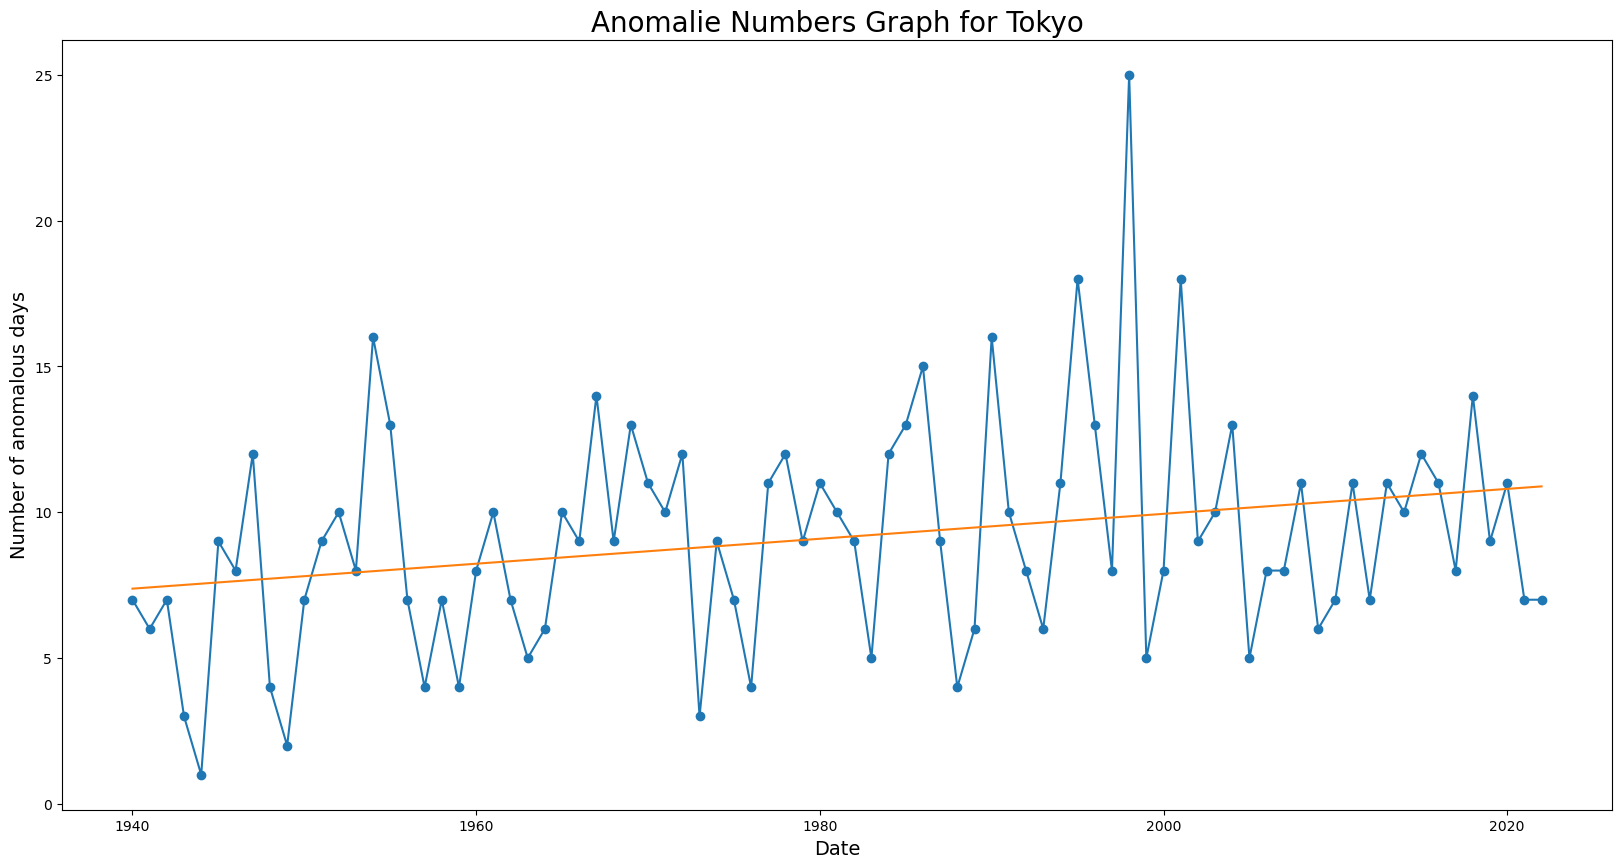

0.04275639141933587 -75.56788128122243 0.264859344078301 0.01553021163925773 0.0172961551780709
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is 0.020639429588710265
For column temperature_2m_max the skew is 0.4951118351476807
For column temperature_2m_min the skew is -0.17816216256273143
For column temperature_2m_mean the skew is 0.036754905479520025
For column apparent_temperature_max the skew is 0.2957237939938822
For column apparent_temperature_min the skew is -0.024298934535221615
For column apparent_temperature_mean the skew is 0.06142084285466246
For column precipitation_sum the skew is 8.48350618462244
For column rain_sum the skew is 8.48350618462244
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.6135495866865175
For column windgusts_10m_max the skew is 0.5125021769686889


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                     Variable         VIF
0                 weathercode    2.085362
1          temperature_2m_max   56.400455
2          temperature_2m_min   91.241584
3         temperature_2m_mean  258.485701
4    apparent_temperature_max   69.009082
5    apparent_temperature_min  111.815377
6   apparent_temperature_mean  308.367502
7           precipitation_sum         inf
8                    rain_sum         inf
9                snowfall_sum         NaN
10          windspeed_10m_max    7.285955
11          windgusts_10m_max    6.716375


/tmp/ipykernel_32/346357692.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_worker.X_total_orig.iloc[:,0]=pd.to_datetime(data_worker.X_total_orig.iloc[:,0],format='%Y-%m-%d')


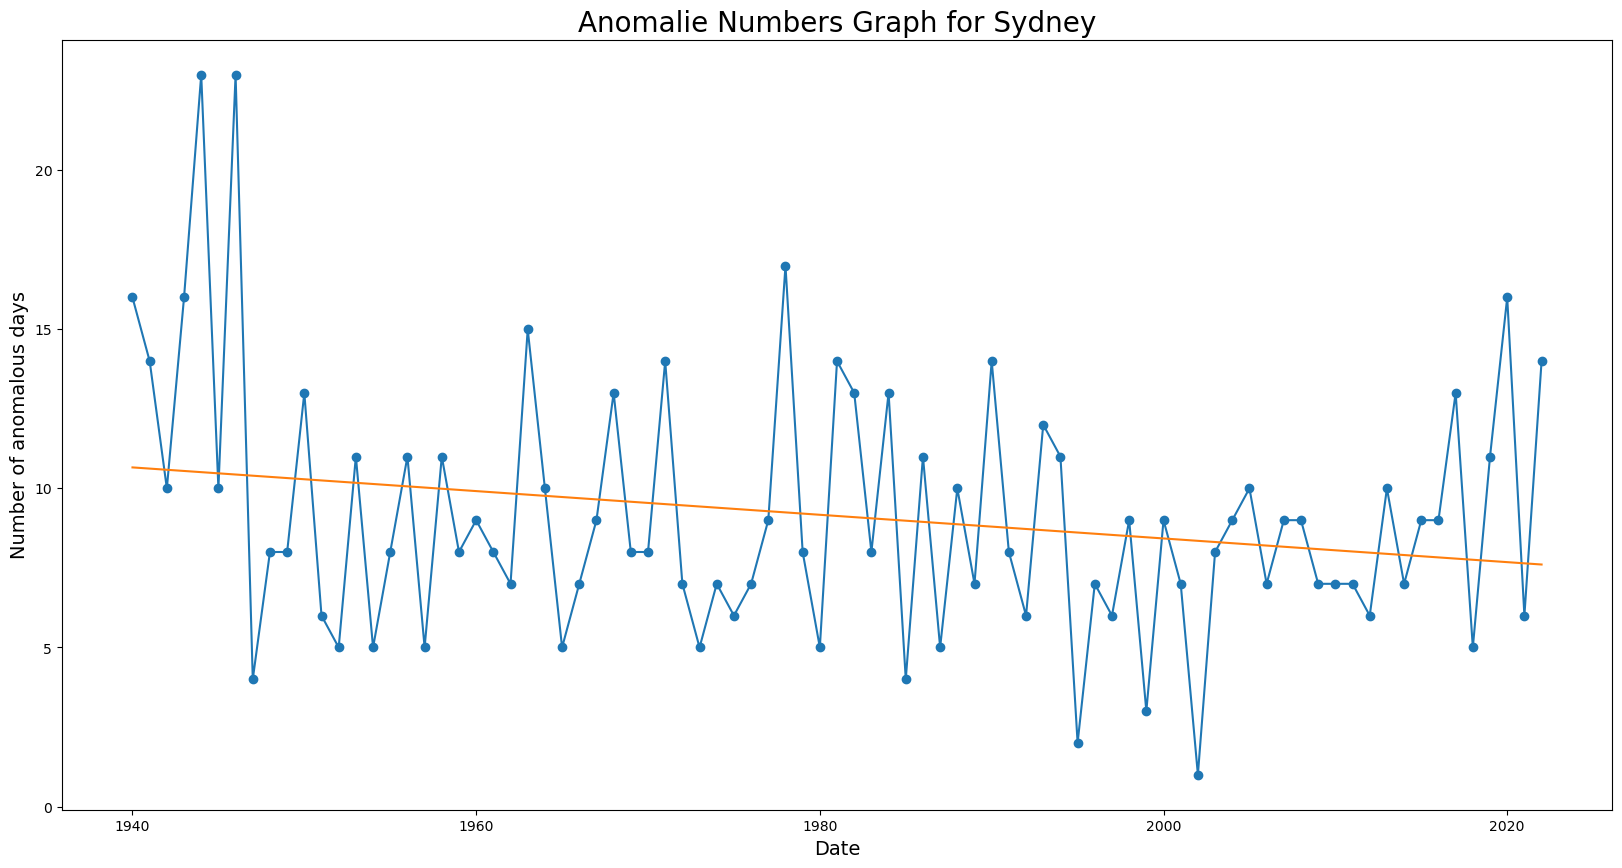

-0.03721506233995214 82.85556861592713 -0.2231089380655297 0.04261890333571501 0.01806641178011935
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is 0.8334423612296618
For column temperature_2m_max the skew is 0.33465064882245416
For column temperature_2m_min the skew is -0.19730892947274598
For column temperature_2m_mean the skew is 0.22056088976206165
For column apparent_temperature_max the skew is 0.2352958914313783
For column apparent_temperature_min the skew is -0.0038513360476145524
For column apparent_temperature_mean the skew is 0.22985093388970082
For column precipitation_sum the skew is 5.105447730015882
For column rain_sum the skew is 5.105447730015882
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.3936365651724929
For column windgusts_10m_max the skew is 0.33729709353522097


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                     Variable         VIF
0                 weathercode    3.035036
1          temperature_2m_max   67.914272
2          temperature_2m_min   51.464041
3         temperature_2m_mean  197.717481
4    apparent_temperature_max   66.114011
5    apparent_temperature_min   60.752814
6   apparent_temperature_mean  201.700187
7           precipitation_sum         inf
8                    rain_sum         inf
9                snowfall_sum         NaN
10          windspeed_10m_max    9.278179
11          windgusts_10m_max    8.943017


/tmp/ipykernel_32/346357692.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_worker.X_total_orig.iloc[:,0]=pd.to_datetime(data_worker.X_total_orig.iloc[:,0],format='%Y-%m-%d')


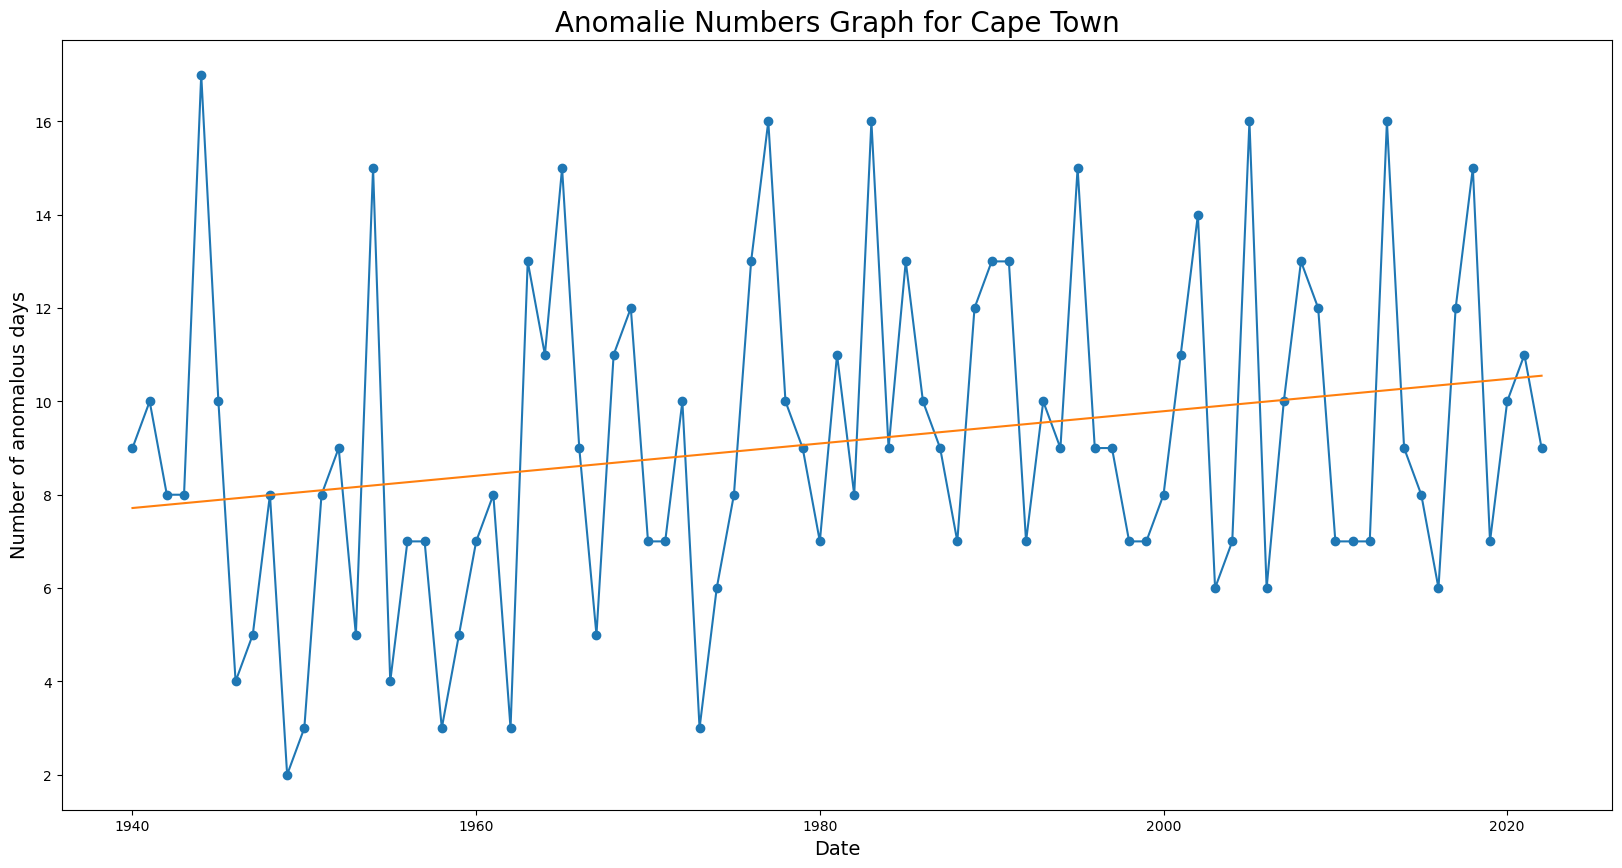

0.03457033709751899 -59.35130766970319 0.23867011719086648 0.029786424803865143 0.015628860942642993
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.2999922908055065
For column temperature_2m_max the skew is 0.10457508779964876
For column temperature_2m_min the skew is -0.2922133845420217
For column temperature_2m_mean the skew is 0.10527013879749203
For column apparent_temperature_max the skew is 0.04293439615508062
For column apparent_temperature_min the skew is -0.17097792398413617
For column apparent_temperature_mean the skew is 0.031549732226600596
For column precipitation_sum the skew is 6.496317103569054
For column rain_sum the skew is 6.496317103569054
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.9159902973145592
For column windgusts_10m_max the skew is 1.0215504610215649


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                     Variable         VIF
0                 weathercode    2.708630
1          temperature_2m_max   54.994228
2          temperature_2m_min   98.539446
3         temperature_2m_mean  184.867915
4    apparent_temperature_max   62.387076
5    apparent_temperature_min  106.486024
6   apparent_temperature_mean  253.666574
7           precipitation_sum         inf
8                    rain_sum         inf
9                snowfall_sum         NaN
10          windspeed_10m_max    4.601435
11          windgusts_10m_max    4.439468


/tmp/ipykernel_32/346357692.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_worker.X_total_orig.iloc[:,0]=pd.to_datetime(data_worker.X_total_orig.iloc[:,0],format='%Y-%m-%d')


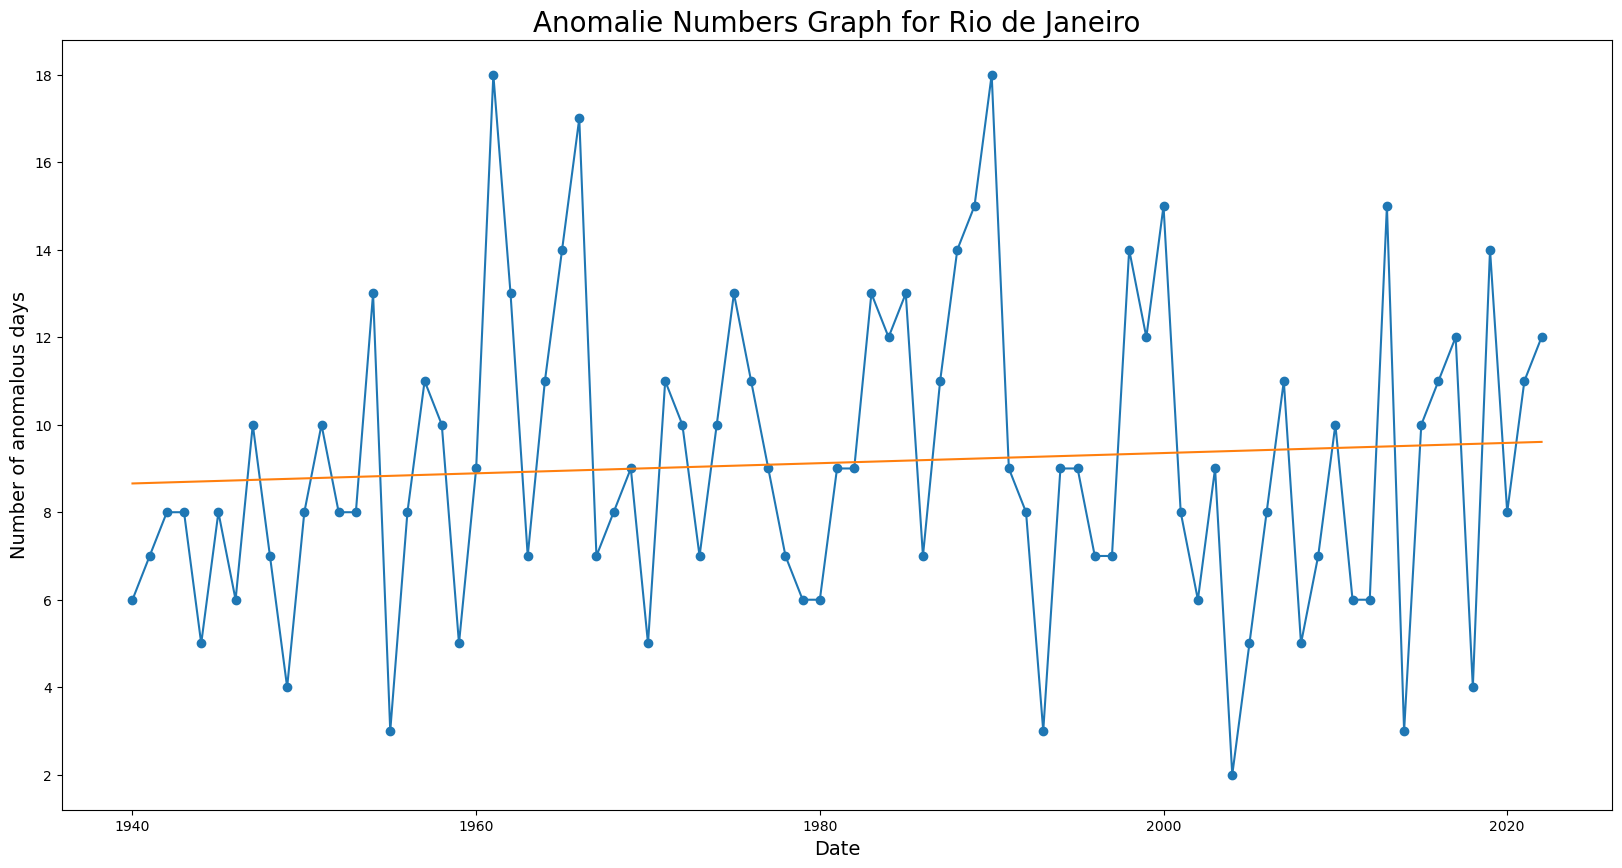

0.011586415347802359 -13.820158683514546 0.08039460991358356 0.46999164625872414 0.015961423093668253
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.23431640326949177
For column temperature_2m_max the skew is -0.21771155980886886
For column temperature_2m_min the skew is -0.5210432540665473
For column temperature_2m_mean the skew is -0.35497134354854176
For column apparent_temperature_max the skew is -0.08501955852936065
For column apparent_temperature_min the skew is -0.3223682789817051
For column apparent_temperature_mean the skew is -0.18808303111563524
For column precipitation_sum the skew is 3.953713544607119
For column rain_sum the skew is 4.7293690214332615
For column snowfall_sum the skew is 5.044673386015413
For column windspeed_10m_max the skew is 0.515999657884203
For column windgusts_10m_max the skew is 0.5110229600028166


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


                     Variable          VIF
0                 weathercode     2.053241
1          temperature_2m_max   775.945923
2          temperature_2m_min   581.901221
3         temperature_2m_mean  2137.879418
4    apparent_temperature_max   849.443540
5    apparent_temperature_min   671.983602
6   apparent_temperature_mean  2436.365571
7           precipitation_sum    53.258457
8                    rain_sum    43.483539
9                snowfall_sum    17.067373
10          windspeed_10m_max    13.549831
11          windgusts_10m_max    12.888687


/tmp/ipykernel_32/346357692.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_worker.X_total_orig.iloc[:,0]=pd.to_datetime(data_worker.X_total_orig.iloc[:,0],format='%Y-%m-%d')


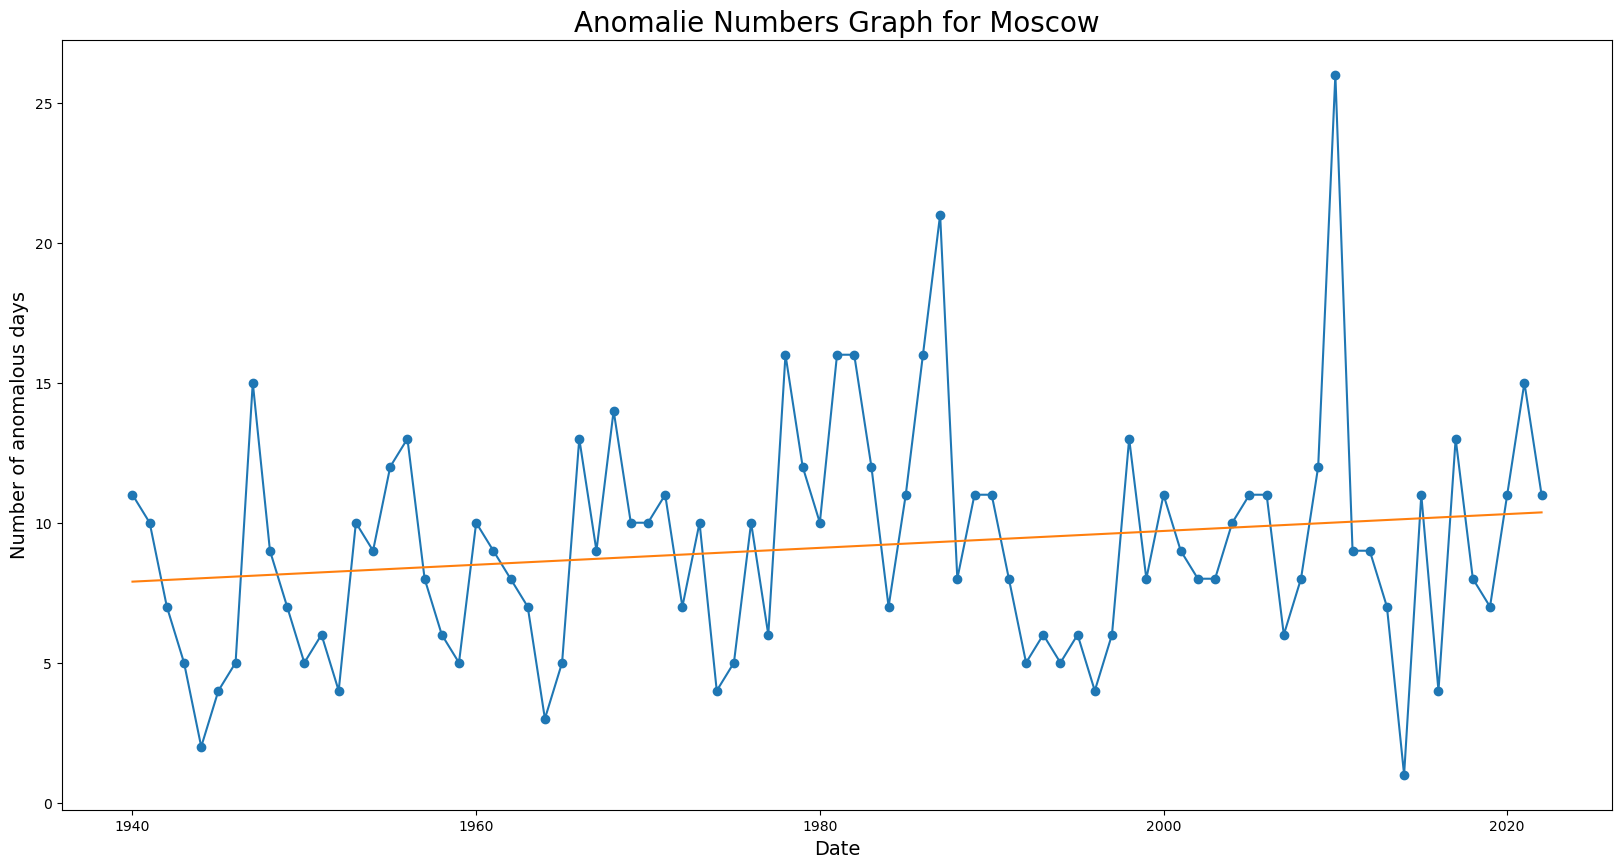

0.030162461693463757 -50.61930649426978 0.1772532821602622 0.10891571501362934 0.01860792823469788
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is 0.035011059609118544
For column temperature_2m_max the skew is -0.1564739475229068
For column temperature_2m_min the skew is -0.31575922628414393
For column temperature_2m_mean the skew is -0.23968979571913565
For column apparent_temperature_max the skew is -0.04773646674202847
For column apparent_temperature_min the skew is -0.13250195007227342
For column apparent_temperature_mean the skew is -0.08962626863452285
For column precipitation_sum the skew is 3.763158960047475
For column rain_sum the skew is 4.202784613586774
For column snowfall_sum the skew is 8.054344952397324
For column windspeed_10m_max the skew is 0.6496999871947604
For column windgusts_10m_max the skew is 0.7963416397602434


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


                     Variable          VIF
0                 weathercode     2.221119
1          temperature_2m_max   282.122598
2          temperature_2m_min   487.432796
3         temperature_2m_mean  1248.879555
4    apparent_temperature_max   297.963719
5    apparent_temperature_min   521.368368
6   apparent_temperature_mean  1310.016898
7           precipitation_sum    57.352035
8                    rain_sum    47.266075
9                snowfall_sum     9.349599
10          windspeed_10m_max     9.603088
11          windgusts_10m_max     8.619317


/tmp/ipykernel_32/346357692.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_worker.X_total_orig.iloc[:,0]=pd.to_datetime(data_worker.X_total_orig.iloc[:,0],format='%Y-%m-%d')


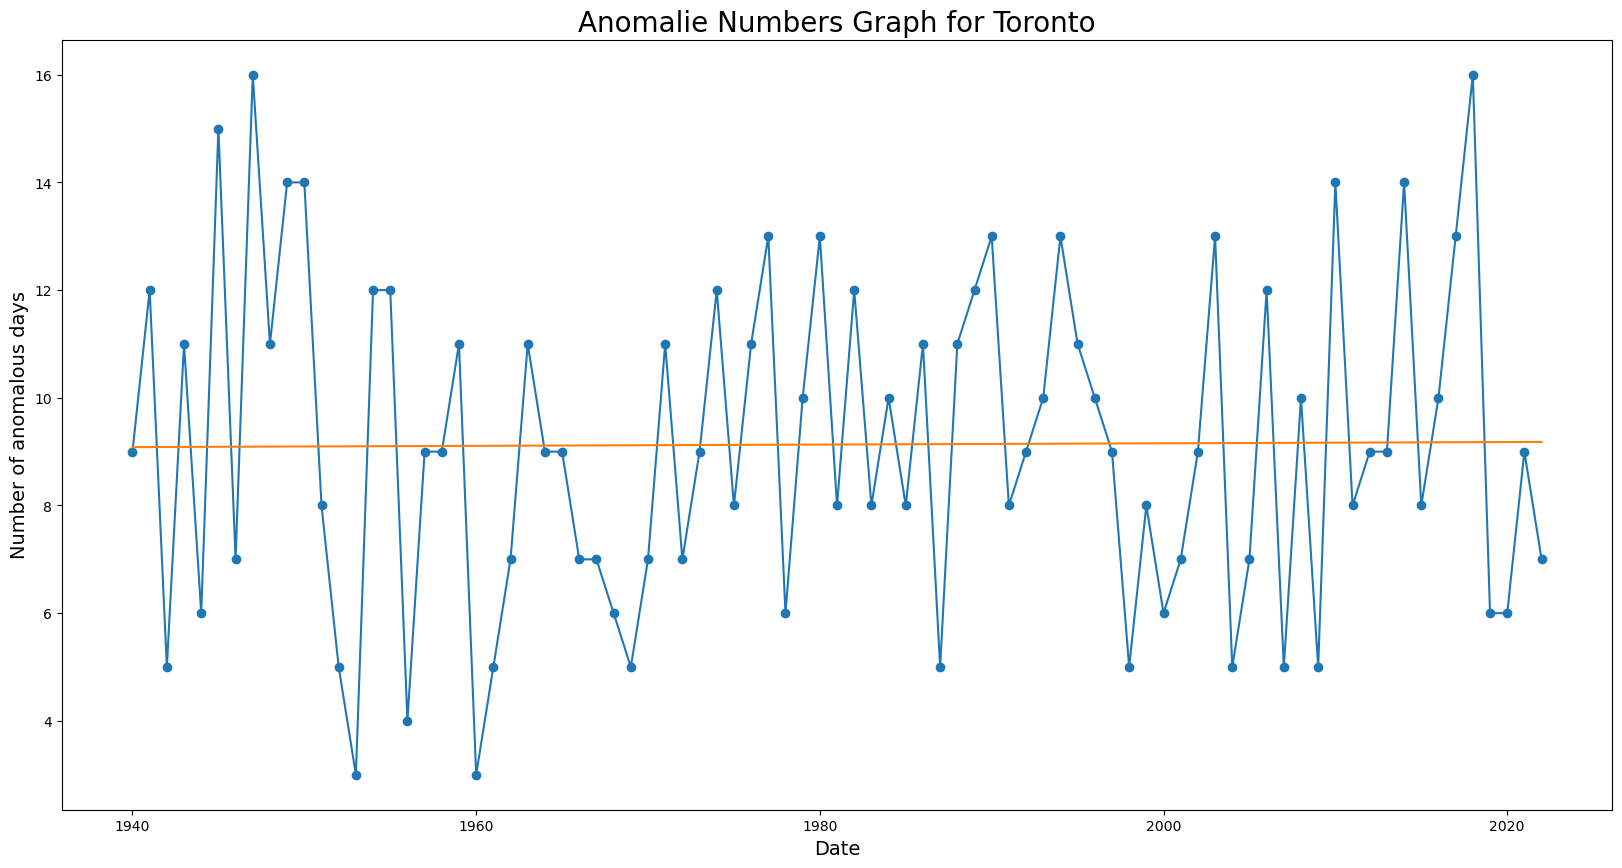

0.001175433441081397 6.80399647369968 0.00922467422593231 0.9340360210601919 0.014157481936210994
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.6475832601399074
For column temperature_2m_max the skew is -0.449814837793761
For column temperature_2m_min the skew is -0.7093471106594645
For column temperature_2m_mean the skew is -0.6058565201835712
For column apparent_temperature_max the skew is -0.26684907013507725
For column apparent_temperature_min the skew is -0.4449045687259984
For column apparent_temperature_mean the skew is -0.3673072776750169
For column precipitation_sum the skew is 2.2179994456313565
For column rain_sum the skew is 2.439724059548076
For column snowfall_sum the skew is 5.179567025300867
For column windspeed_10m_max the skew is 0.6633498304516261
For column windgusts_10m_max the skew is 0.8079480099292335


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


                     Variable         VIF
0                 weathercode    2.296348
1          temperature_2m_max  127.128838
2          temperature_2m_min  113.160793
3         temperature_2m_mean  449.713252
4    apparent_temperature_max  143.044229
5    apparent_temperature_min  146.310726
6   apparent_temperature_mean  539.508918
7           precipitation_sum   41.299547
8                    rain_sum   33.437911
9                snowfall_sum    6.324108
10          windspeed_10m_max   23.456470
11          windgusts_10m_max   22.093503


/tmp/ipykernel_32/346357692.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_worker.X_total_orig.iloc[:,0]=pd.to_datetime(data_worker.X_total_orig.iloc[:,0],format='%Y-%m-%d')


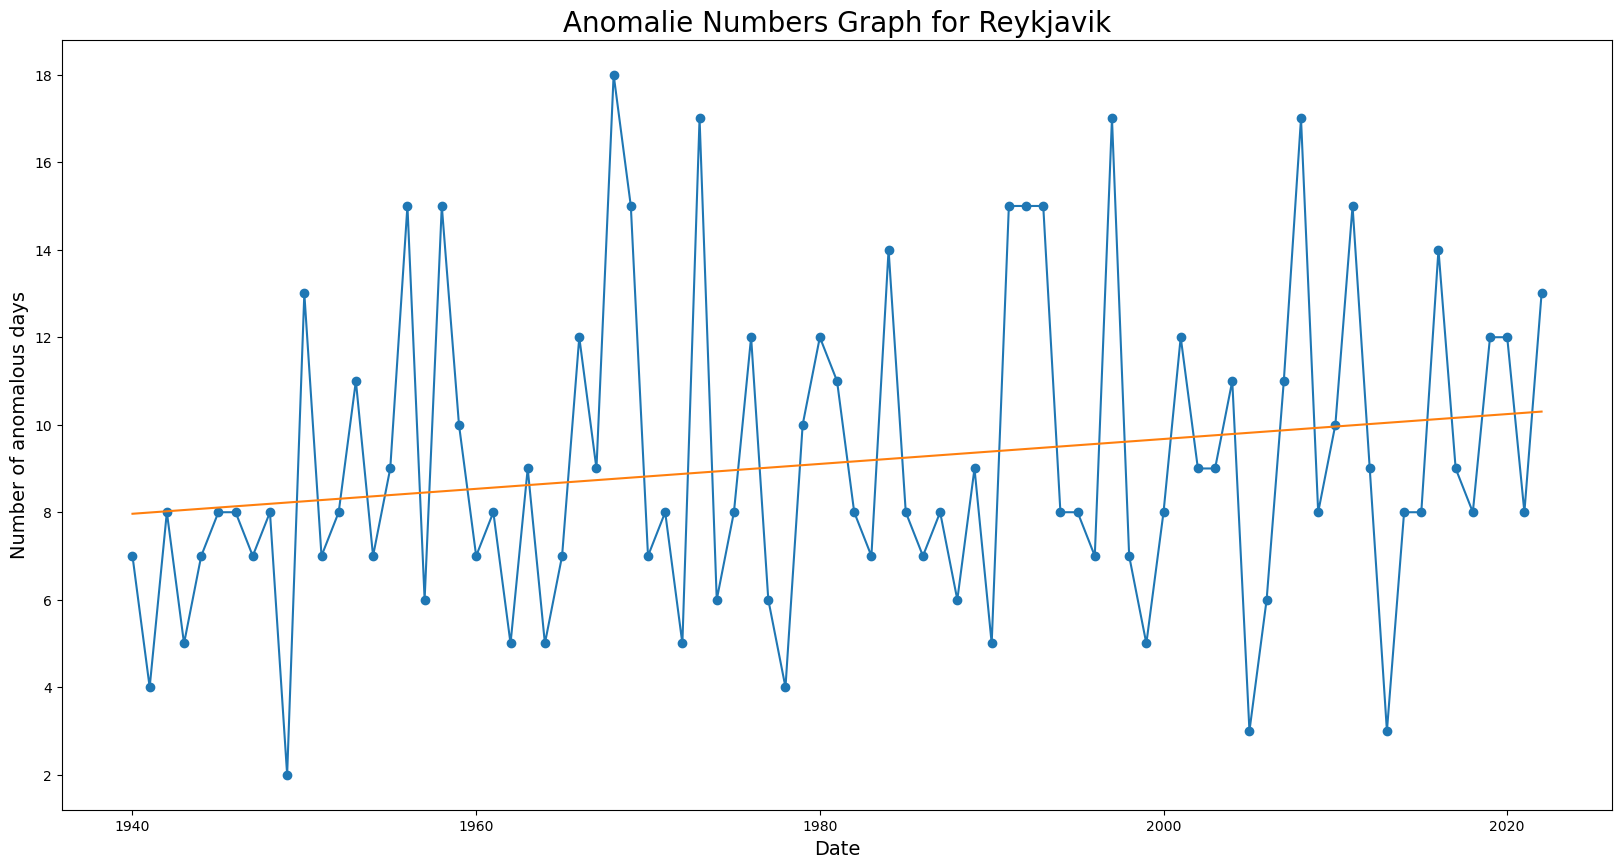

0.02848327106334747 -47.292829856009405 0.19117716121849573 0.08339826565748781 0.01624898459388774


In [972]:
#for more than 2 dimensions: minPts=2*dim (Sander et al., 1998)
for city in location_names:
    data_worker = DataWorker(weather_df,city)
    data_worker.na_check().datetime_index_na_check().check_duplicates().check_uniform().get_float_cols().compute_vif()
    data_worker.data.drop(['rain_sum','snowfall_sum','temperature_2m_mean','apparent_temperature_mean','apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max'],axis=1,inplace=True)
    data_worker.float_columns=[col for col in data_worker.float_columns if col not in ['rain_sum','snowfall_sum','temperature_2m_mean','apparent_temperature_mean','apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max']]
    data_worker.train_test().normalize()
    clustering = OPTICS(min_samples=2*data_worker.X_total.shape[1],n_jobs=-1,algorithm='brute').fit(data_worker.X_total)
    scores = clustering.core_distances_ 
    thresh = quantile(scores, .975)
    index = where(scores >= thresh)
    data_worker.X_total_orig=pd.DataFrame(data_worker.X_total_orig)
    data_worker.X_total_orig.iloc[:,0]=pd.to_datetime(data_worker.X_total_orig.iloc[:,0],format='%Y-%m-%d')
    outliers = data_worker.X_total_orig.iloc[index]#.groupby(data_worker.X_total_orig.iloc[:,0].dt.year).count()
    outliers=pd.DataFrame(outliers)
    outliers.to_csv(f'OPTICS_outliers_{city}.csv')
    outliers = data_worker.X_total_orig.iloc[index].groupby(data_worker.X_total_orig.iloc[:,0].dt.year).count()
    plt.figure(figsize=(20,10))
    plt.plot(outliers.iloc[:,-1])
    a, b = np.polyfit(np.array(np.linspace(min(data_worker.X_total_orig.iloc[:,0].dt.year),max(data_worker.X_total_orig.iloc[:,0].dt.year),num=len(outliers))), outliers.iloc[:,-1], 1)
    x=np.array(np.linspace(min(data_worker.X_total_orig.iloc[:,0].dt.year),max(data_worker.X_total_orig.iloc[:,0].dt.year),num=len(outliers)))
    y=outliers.iloc[:,-1]
    plt.scatter(x, y)

    #add line of best fit to plot
    plt.plot(x, a*x+b)   
    plt.title(f'Anomalie Numbers Graph for {city}',fontsize=20)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Number of anomalous days',fontsize=14)
    plt.show()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(slope,intercept,r_value,p_value,std_err)

Let's try a novelty detection algorithm instead


Find best n_neighbors value

Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.12781792842656425
For column temperature_2m_max the skew is -0.06492773605392985
For column temperature_2m_min the skew is -0.09129138776801797
For column temperature_2m_mean the skew is -0.08450816366995637
For column apparent_temperature_max the skew is 0.054137987435768246
For column apparent_temperature_min the skew is 0.060531648905988625
For column apparent_temperature_mean the skew is 0.04498808580258212
For column precipitation_sum the skew is 5.58376489366953
For column rain_sum the skew is 5.664703032910778
For column snowfall_sum the skew is 26.862035871026478
For column windspeed_10m_max the skew is 1.403677934511822
For column windgusts_10m_max the skew is 1.5374839077880171
----------
For column weathercode the skew is -0.12781792842656425
For column temperature_2m_max the skew is -0.0

/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


             Variable       VIF
0         weathercode  2.224142
1  temperature_2m_max  1.011842
2   precipitation_sum  2.310942
3   windgusts_10m_max  1.068071


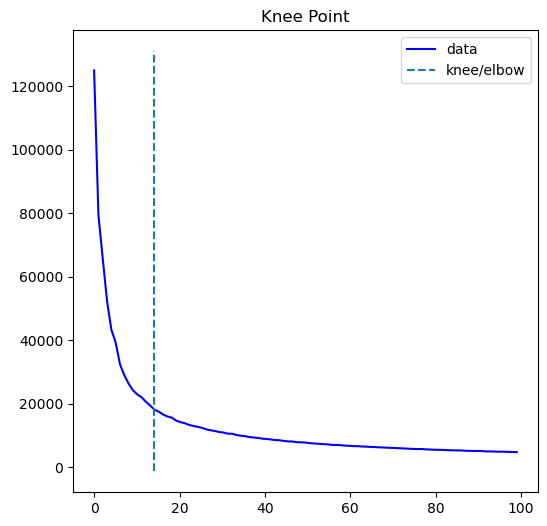

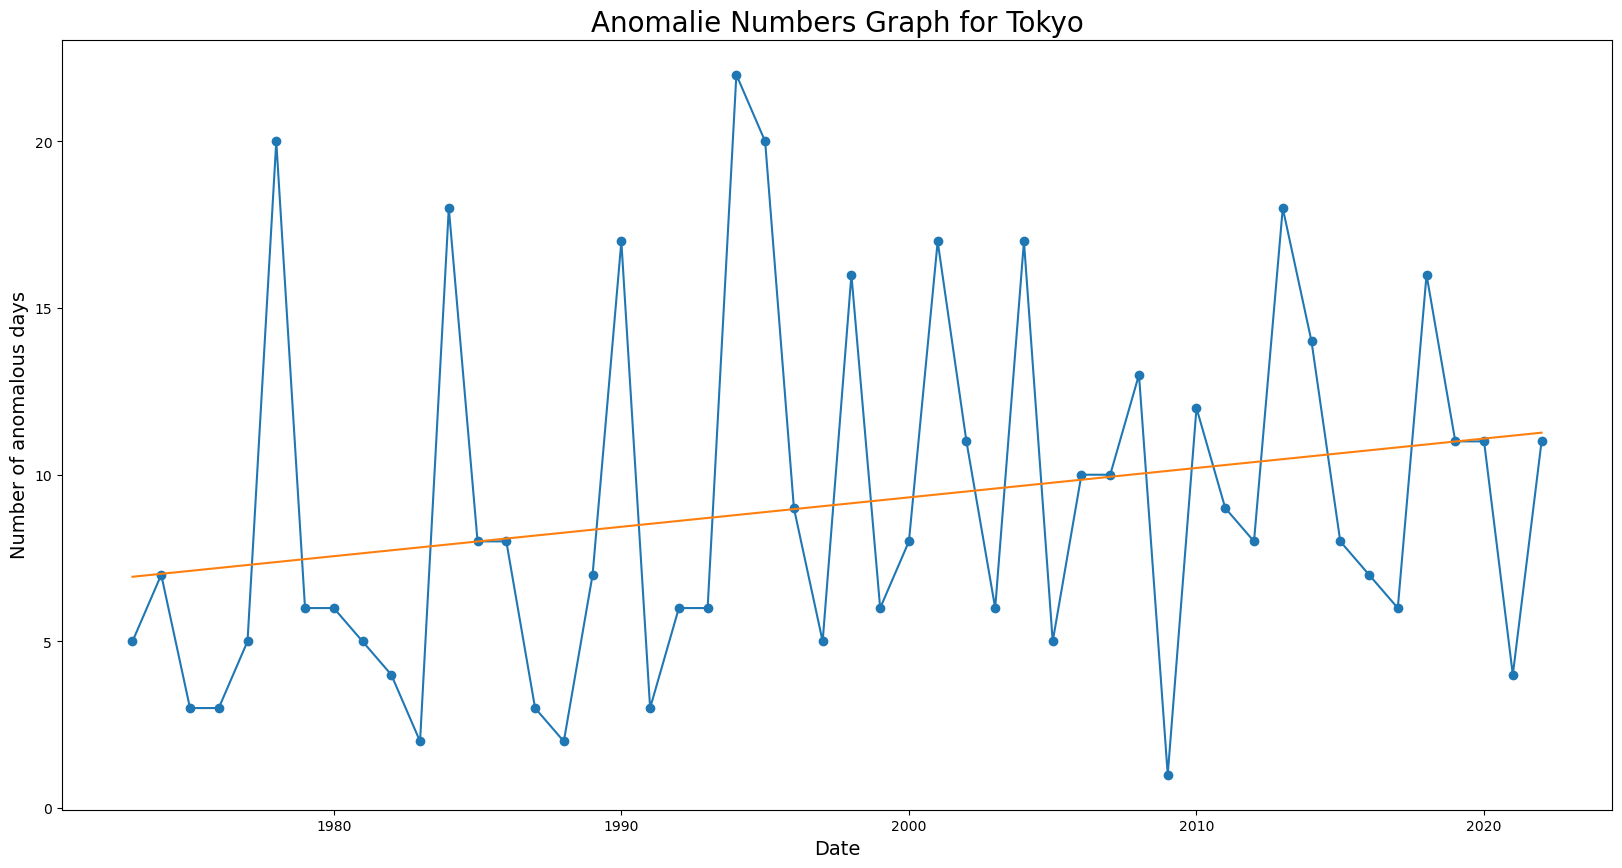

0.08821128451380551 -167.1020408163265 0.2366695769330067 0.09796885814679261 0.05226900314549788
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is 0.020639429588710265
For column temperature_2m_max the skew is 0.4951118351476807
For column temperature_2m_min the skew is -0.17816216256273143
For column temperature_2m_mean the skew is 0.036754905479520025
For column apparent_temperature_max the skew is 0.2957237939938822
For column apparent_temperature_min the skew is -0.024298934535221615
For column apparent_temperature_mean the skew is 0.06142084285466246
For column precipitation_sum the skew is 8.48350618462244
For column rain_sum the skew is 8.48350618462244
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.6135495866865175
For column windgusts_10m_max the skew is 0.5125021769686889
----------
For column weathercode t

/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


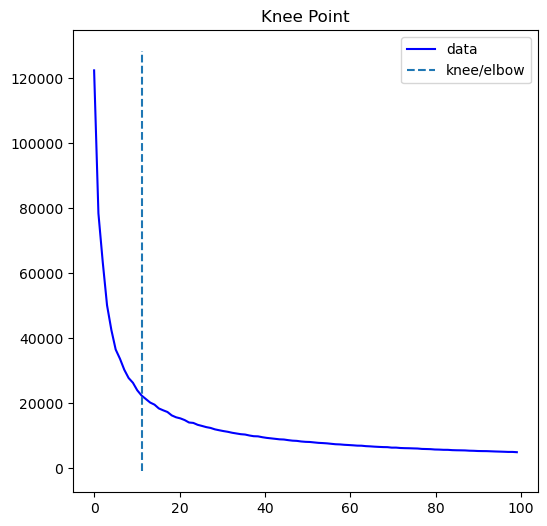

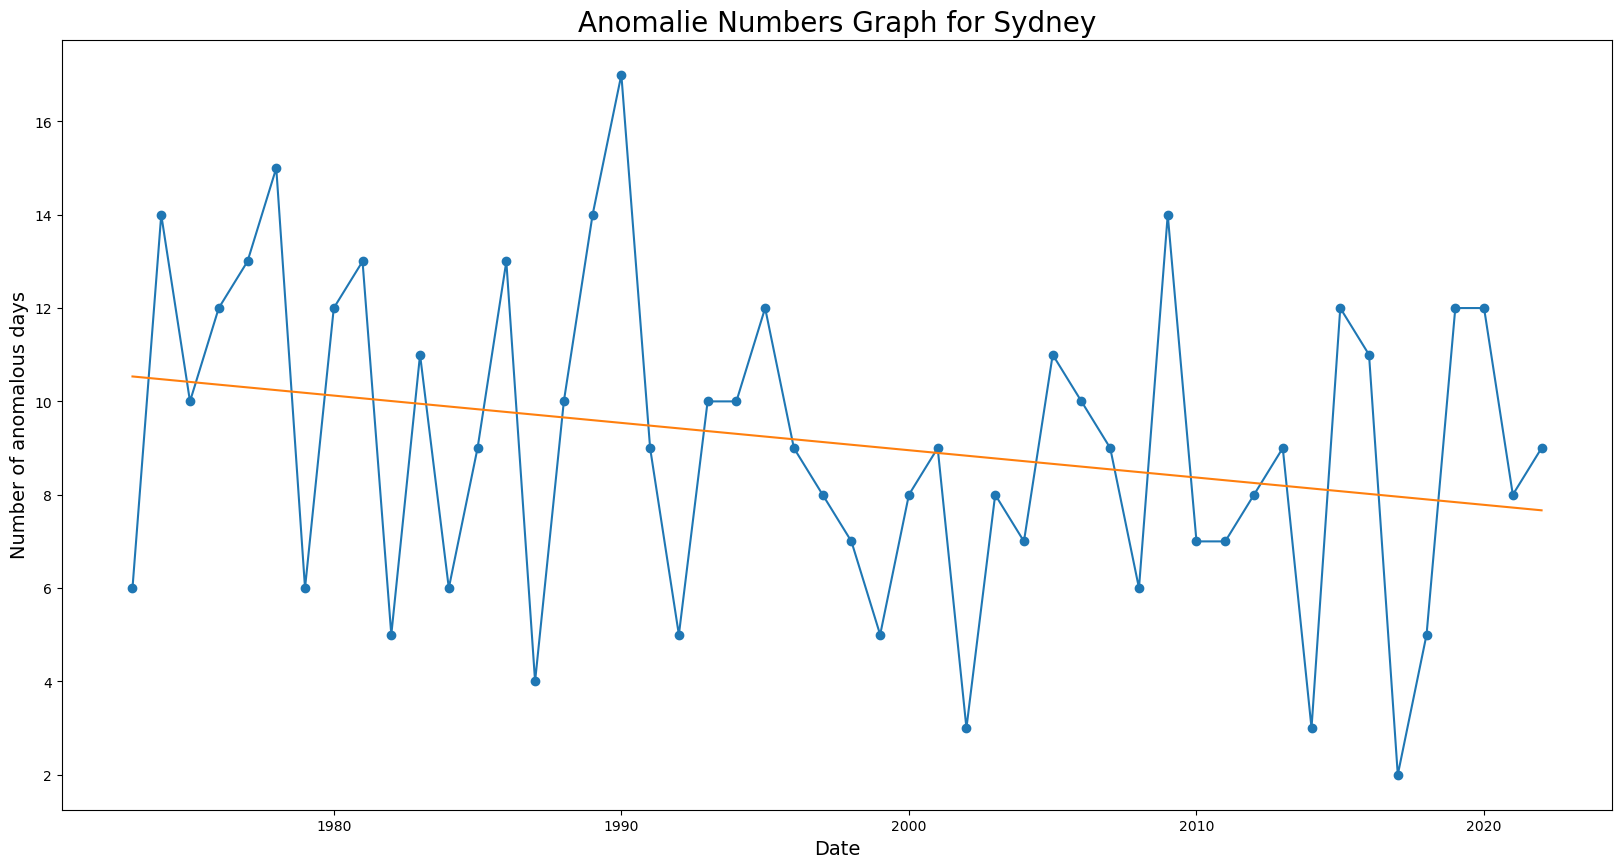

-0.058535414165666266 126.02448979591836 -0.2522948550910114 0.077129582427074 0.032404711945557586
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is 0.8334423612296618
For column temperature_2m_max the skew is 0.33465064882245416
For column temperature_2m_min the skew is -0.19730892947274598
For column temperature_2m_mean the skew is 0.22056088976206165
For column apparent_temperature_max the skew is 0.2352958914313783
For column apparent_temperature_min the skew is -0.0038513360476145524
For column apparent_temperature_mean the skew is 0.22985093388970082
For column precipitation_sum the skew is 5.105447730015882
For column rain_sum the skew is 5.105447730015882
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.3936365651724929
For column windgusts_10m_max the skew is 0.33729709353522097
----------
For column weatherco

/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


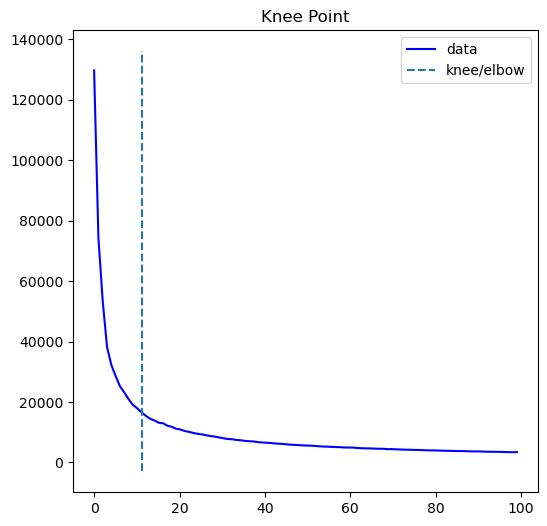

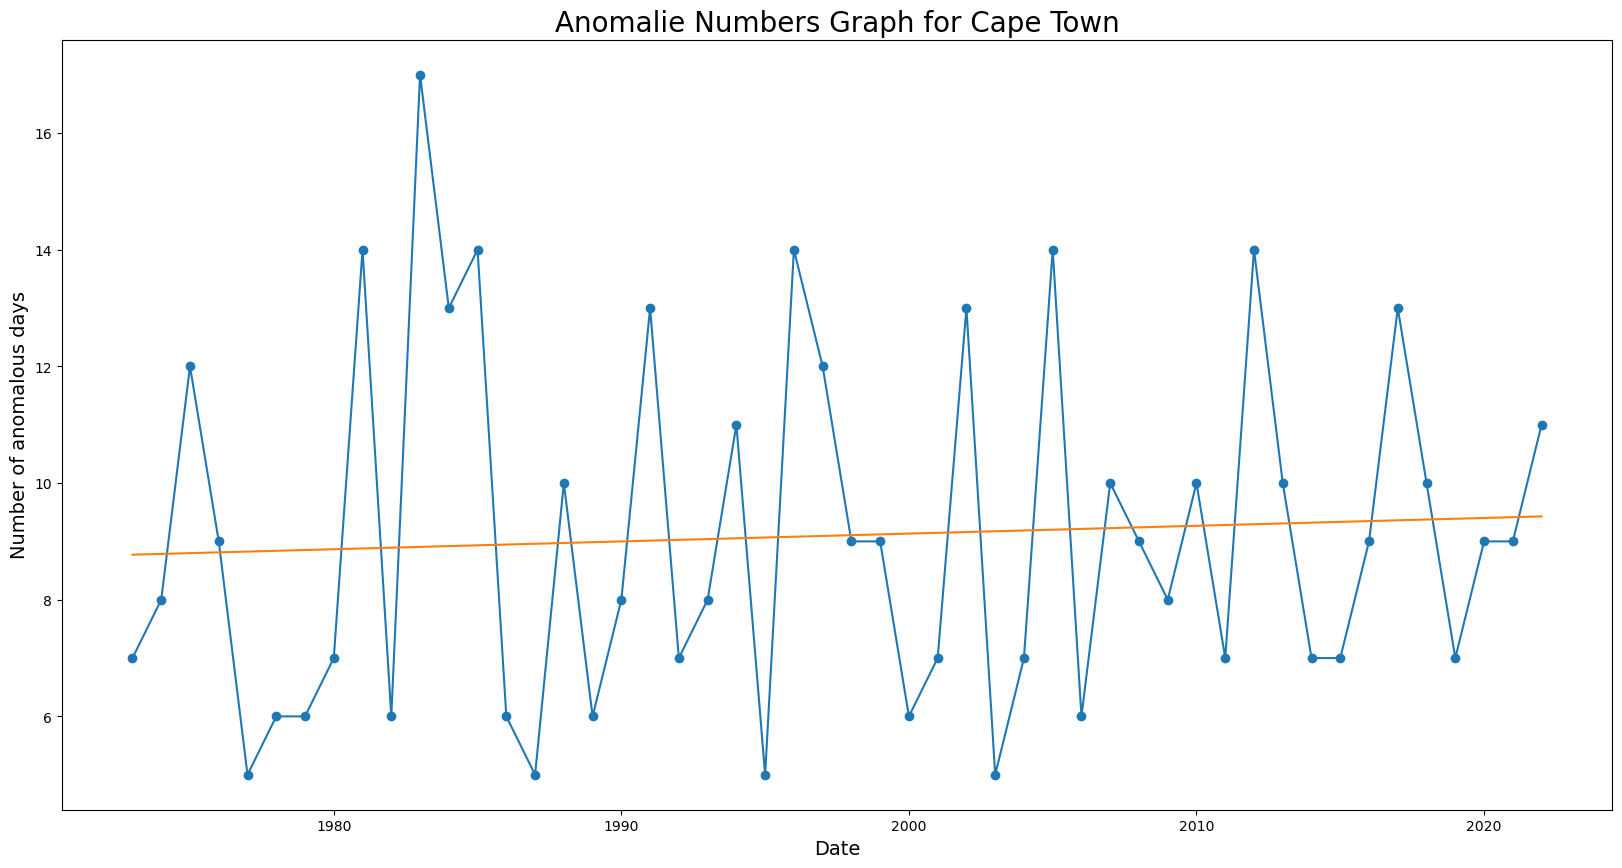

0.013397358943577433 -17.66122448979592 0.0644094072969483 0.6567637082593323 0.029960326856175546
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.2999922908055065
For column temperature_2m_max the skew is 0.10457508779964876
For column temperature_2m_min the skew is -0.2922133845420217
For column temperature_2m_mean the skew is 0.10527013879749203
For column apparent_temperature_max the skew is 0.04293439615508062
For column apparent_temperature_min the skew is -0.17097792398413617
For column apparent_temperature_mean the skew is 0.031549732226600596
For column precipitation_sum the skew is 6.496317103569054
For column rain_sum the skew is 6.496317103569054
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.9159902973145592
For column windgusts_10m_max the skew is 1.0215504610215649
----------
For column weathercode

/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


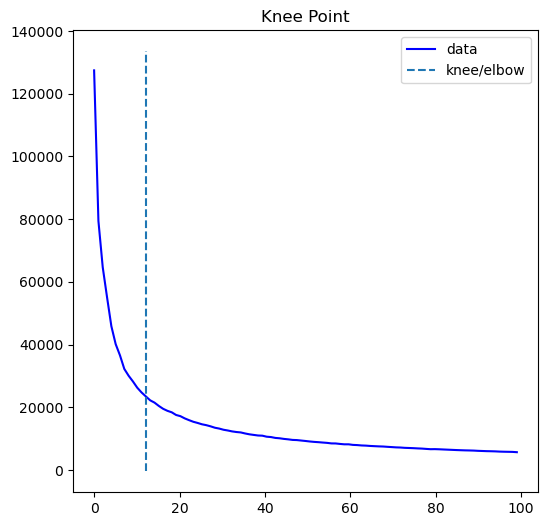

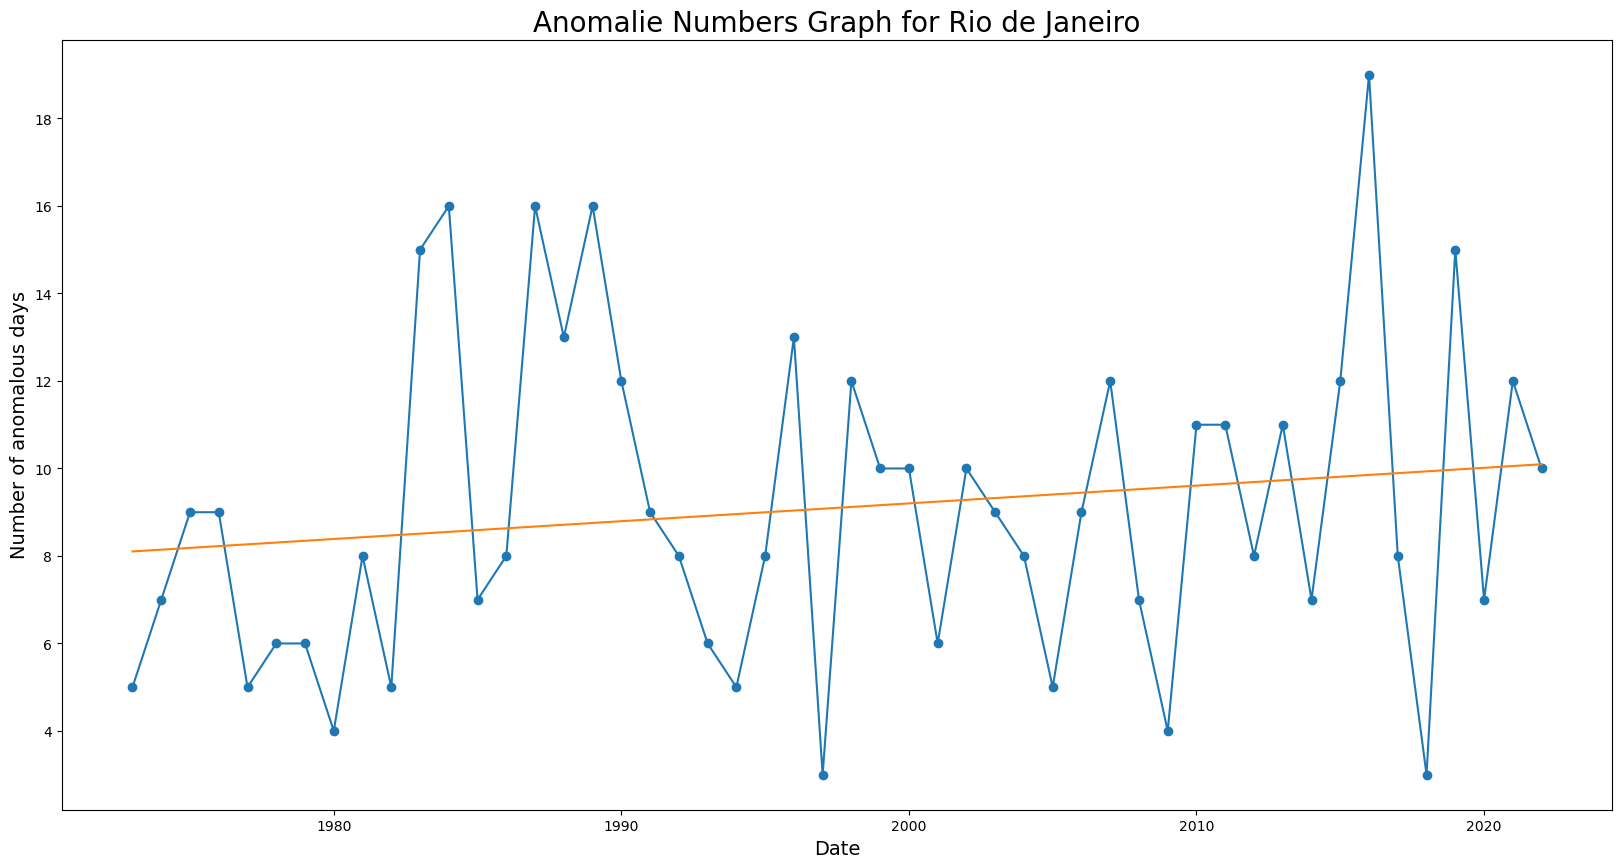

0.04067226890756303 -72.14285714285715 0.15956660576022874 0.26834642982763984 0.03631911644744546
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.23431640326949177
For column temperature_2m_max the skew is -0.21771155980886886
For column temperature_2m_min the skew is -0.5210432540665473
For column temperature_2m_mean the skew is -0.35497134354854176
For column apparent_temperature_max the skew is -0.08501955852936065
For column apparent_temperature_min the skew is -0.3223682789817051
For column apparent_temperature_mean the skew is -0.18808303111563524
For column precipitation_sum the skew is 3.953713544607119
For column rain_sum the skew is 4.7293690214332615
For column snowfall_sum the skew is 5.044673386015413
For column windspeed_10m_max the skew is 0.515999657884203
For column windgusts_10m_max the skew is 0.5110229600028166
----------
For

/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


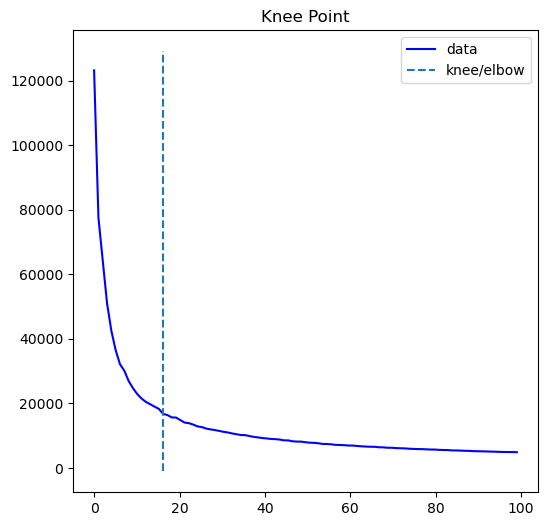

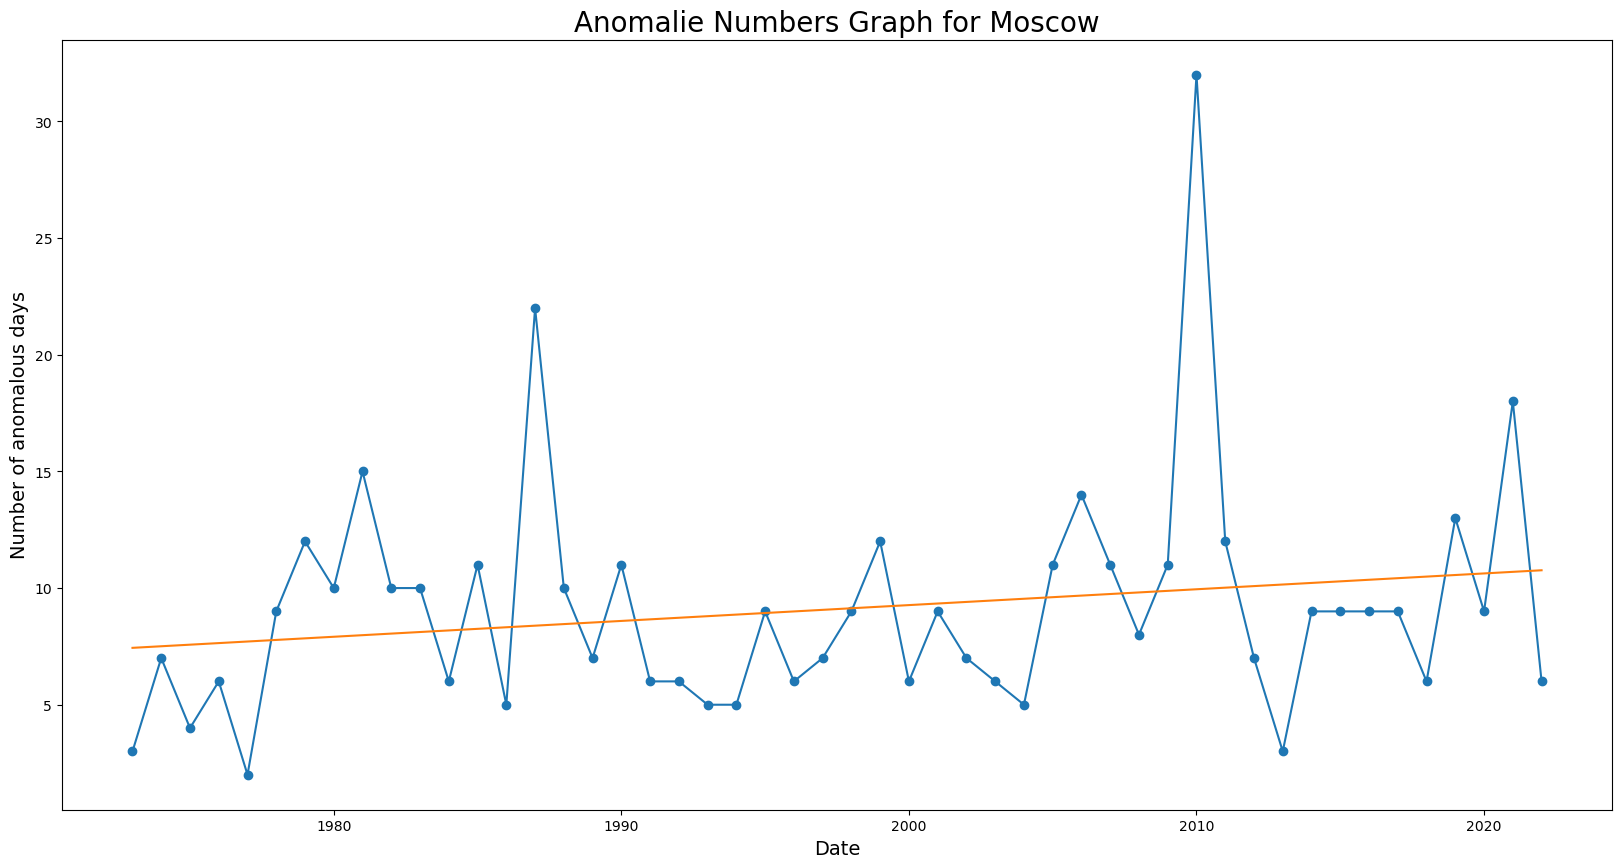

0.06785114045618244 -126.43265306122444 0.19834529011143912 0.16733979554681772 0.04839486712246388
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is 0.035011059609118544
For column temperature_2m_max the skew is -0.1564739475229068
For column temperature_2m_min the skew is -0.31575922628414393
For column temperature_2m_mean the skew is -0.23968979571913565
For column apparent_temperature_max the skew is -0.04773646674202847
For column apparent_temperature_min the skew is -0.13250195007227342
For column apparent_temperature_mean the skew is -0.08962626863452285
For column precipitation_sum the skew is 3.763158960047475
For column rain_sum the skew is 4.202784613586774
For column snowfall_sum the skew is 8.054344952397324
For column windspeed_10m_max the skew is 0.6496999871947604
For column windgusts_10m_max the skew is 0.7963416397602434
----------
F

/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


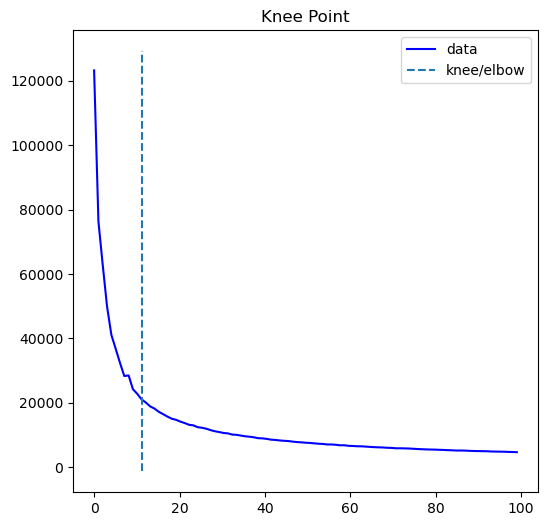

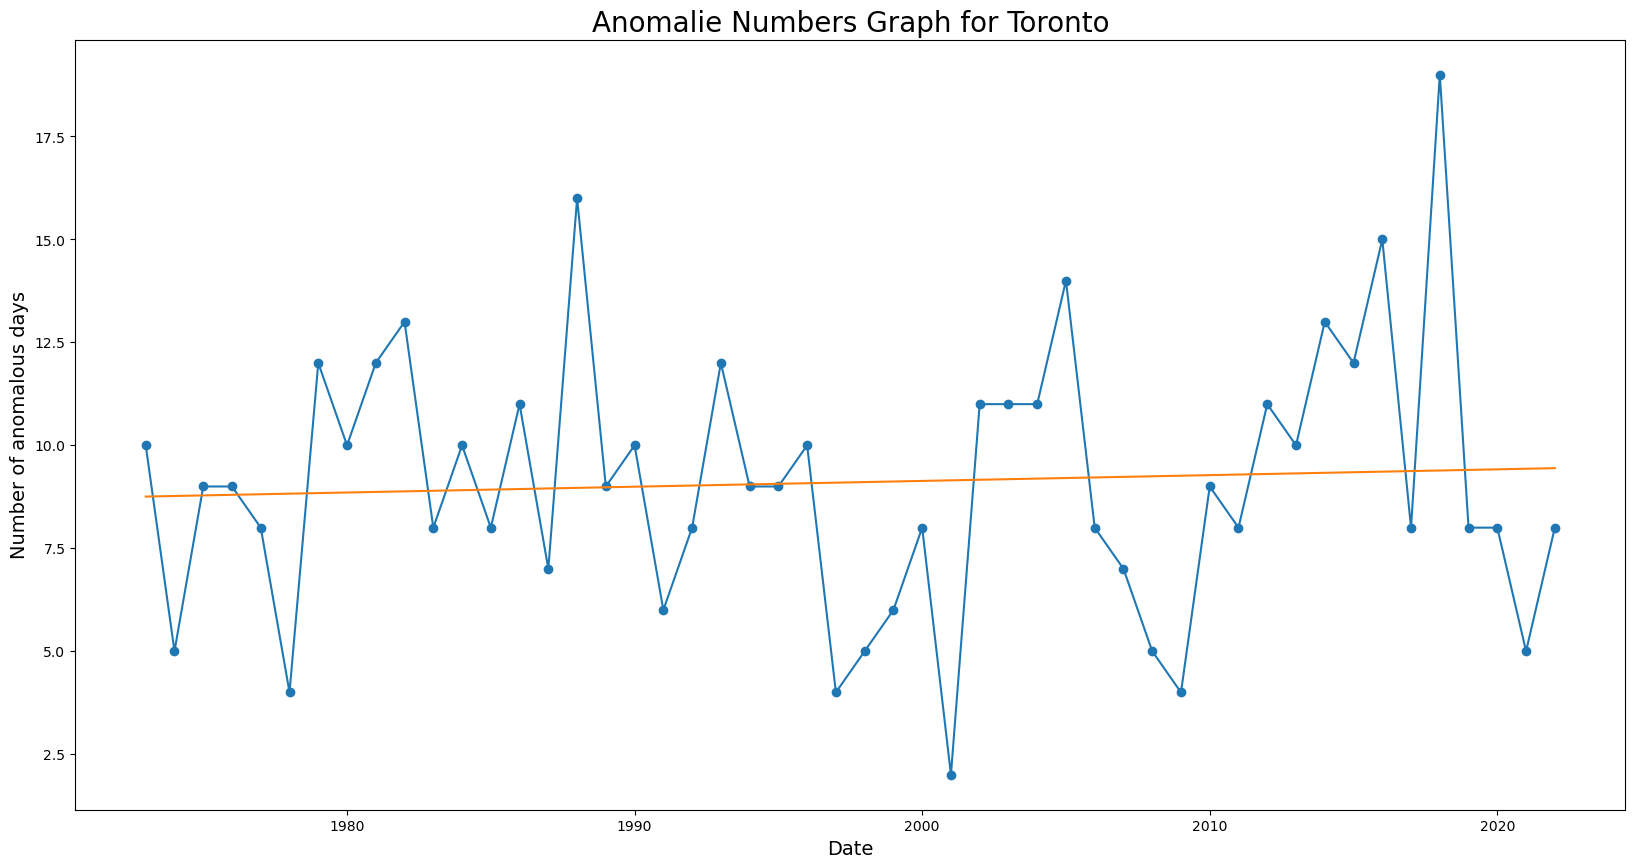

0.014069627851140453 -19.004081632653055 0.06245074471912768 0.6665808767094898 0.03245456699151998
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.6475832601399074
For column temperature_2m_max the skew is -0.449814837793761
For column temperature_2m_min the skew is -0.7093471106594645
For column temperature_2m_mean the skew is -0.6058565201835712
For column apparent_temperature_max the skew is -0.26684907013507725
For column apparent_temperature_min the skew is -0.4449045687259984
For column apparent_temperature_mean the skew is -0.3673072776750169
For column precipitation_sum the skew is 2.2179994456313565
For column rain_sum the skew is 2.439724059548076
For column snowfall_sum the skew is 5.179567025300867
For column windspeed_10m_max the skew is 0.6633498304516261
For column windgusts_10m_max the skew is 0.8079480099292335
----------
For co

/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


             Variable       VIF
0         weathercode  2.076410
1  temperature_2m_max  1.090680
2   precipitation_sum  2.442269
3   windgusts_10m_max  1.376561


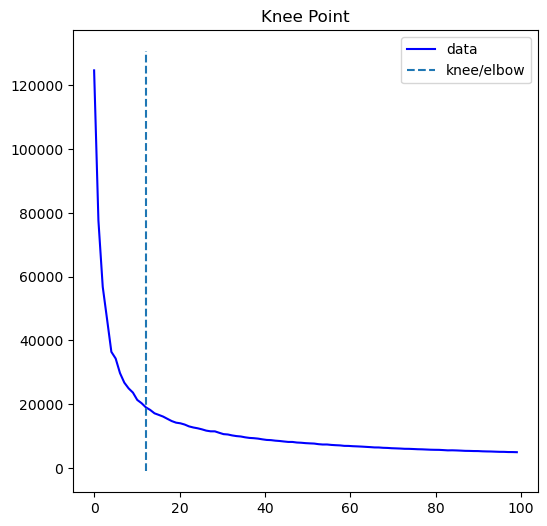

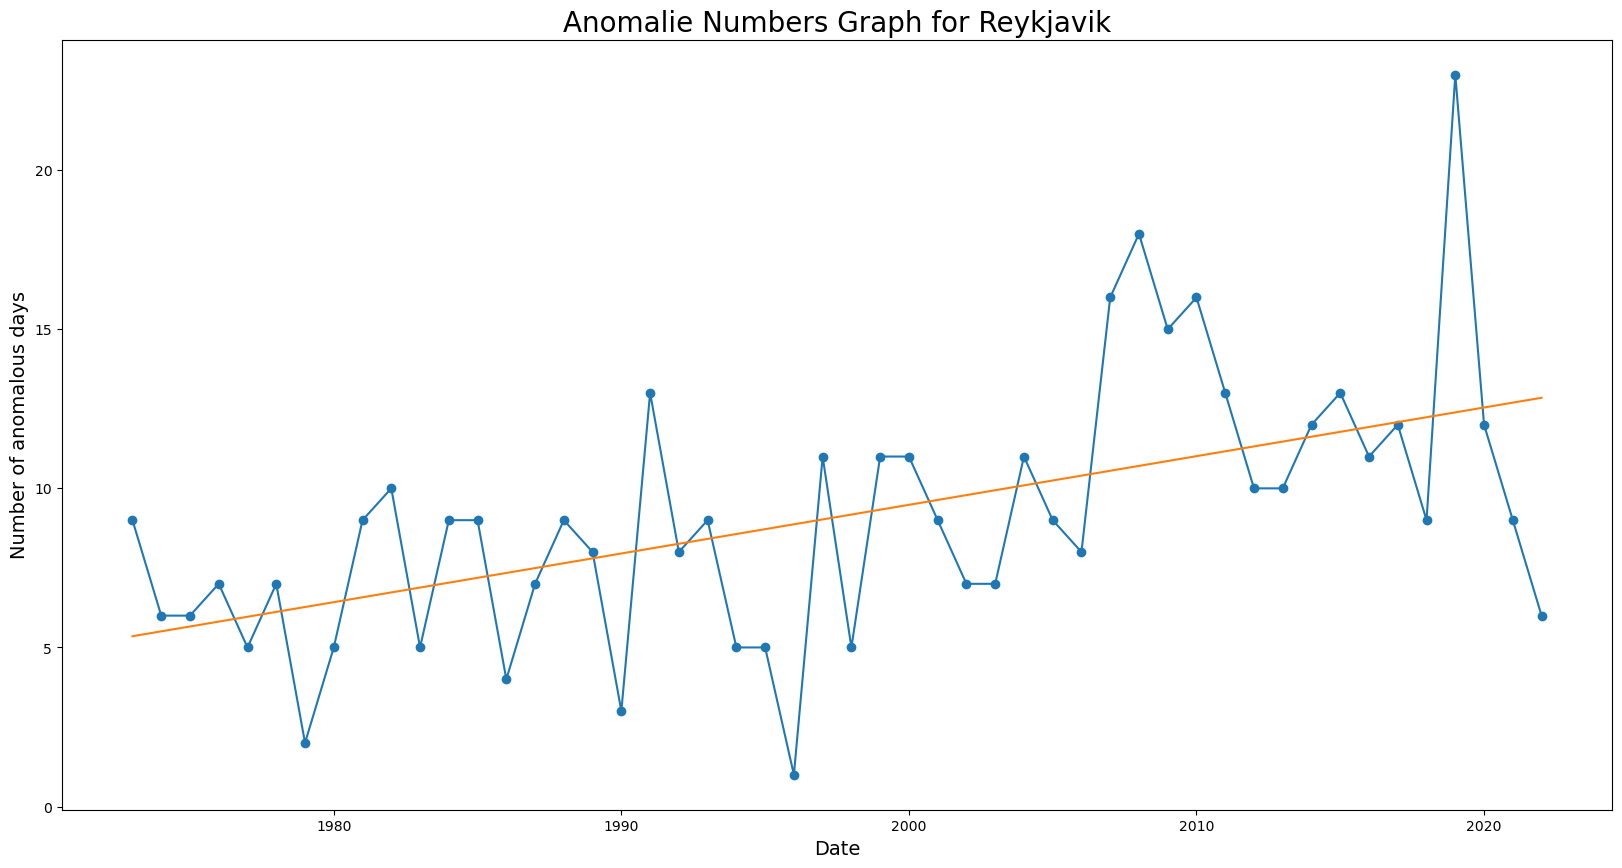

0.15294117647058825 -296.4 0.5421952111443106 4.761015962432346e-05 0.03421038574962919


In [986]:
for city in location_names:
    data_worker = DataWorker(weather_df,city)
    data_worker.na_check().datetime_index_na_check().check_duplicates().get_float_cols().check_uniform()
    data_worker.data.drop(['rain_sum','snowfall_sum','temperature_2m_mean','apparent_temperature_mean','apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max'],axis=1,inplace=True)
    data_worker.float_columns=[col for col in data_worker.float_columns if col not in ['rain_sum','snowfall_sum','temperature_2m_mean','apparent_temperature_mean','apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max']]
    print('-'*10)
    data_worker.check_uniform(False).train_test().normalize().compute_vif()
    
    distortions = []
    K = range(1,100)
    for k in K:
        kmeanModel = KMeans(n_clusters=k,n_init='auto')
        kmeanModel.fit(data_worker.X_total)
        distortions.append(kmeanModel.inertia_)
    data_worker.X_train_orig = pd.DataFrame(data_worker.X_train_orig)
    x = np.array(np.linspace(0,len(distortions),len(distortions)))
    y = distortions
    kneedle = KneeLocator(x, y, S=3.0, curve="convex", direction="decreasing",online=True)
    kneedle.plot_knee()
    n_neighbors=int(kneedle.knee)
    
    
    model=LocalOutlierFactor(n_neighbors=n_neighbors,n_jobs=-1,novelty=True,algorithm='brute')
    model.fit(data_worker.X_train)
    scores = model.decision_function(data_worker.X_test)
    thresh = quantile(scores, .025)
    index = where(scores <= thresh)
    outliers = data_worker.X_test_orig.iloc[index]
    outliers=pd.DataFrame(outliers)
    outliers.to_csv(f'LocalOutlierFactor_outliers_{city}.csv')

    
    data_worker.X_test_orig['time']=pd.to_datetime(data_worker.X_test_orig.loc[:,'time'],format='%Y-%m-%d')
    outliers = data_worker.X_test_orig.iloc[index].groupby(data_worker.X_test_orig['time'].dt.year).count()
    plt.figure(figsize=(20,10))
    plt.plot(outliers.iloc[:,-1])
    a, b = np.polyfit(np.array(np.linspace(min(data_worker.X_test_orig['time'].dt.year),max(data_worker.X_test_orig['time'].dt.year),num=len(outliers))), outliers.iloc[:,-1], 1)
    x=np.array(np.linspace(min(data_worker.X_test_orig['time'].dt.year),max(data_worker.X_test_orig['time'].dt.year),num=len(outliers)))
    y=outliers.iloc[:,-1]
    plt.scatter(x, y)

    #add line of best fit to plot
    plt.plot(x, a*x+b)   
    plt.title(f'Anomalie Numbers Graph for {city}',fontsize=20)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Number of anomalous days',fontsize=14)
    plt.show()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(slope,intercept,r_value,p_value,std_err)

Hyperparameter search for isolation forest

Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is -0.12781792842656425
For column temperature_2m_max the skew is -0.06492773605392985
For column temperature_2m_min the skew is -0.09129138776801797
For column temperature_2m_mean the skew is -0.08450816366995637
For column apparent_temperature_max the skew is 0.054137987435768246
For column apparent_temperature_min the skew is 0.060531648905988625
For column apparent_temperature_mean the skew is 0.04498808580258212
For column precipitation_sum the skew is 5.58376489366953
For column rain_sum the skew is 5.664703032910778
For column snowfall_sum the skew is 26.862035871026478
For column windspeed_10m_max the skew is 1.403677934511822
For column windgusts_10m_max the skew is 1.5374839077880171


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


                     Variable            VIF
0                 weathercode       1.481645
1          temperature_2m_max     217.052844
2          temperature_2m_min     330.277486
3         temperature_2m_mean    1001.590895
4    apparent_temperature_max     208.582491
5    apparent_temperature_min     336.875550
6   apparent_temperature_mean     983.677635
7           precipitation_sum  749162.059978
8                    rain_sum  736962.945496
9                snowfall_sum    6990.820275
10          windspeed_10m_max       9.121302
11          windgusts_10m_max       8.415139


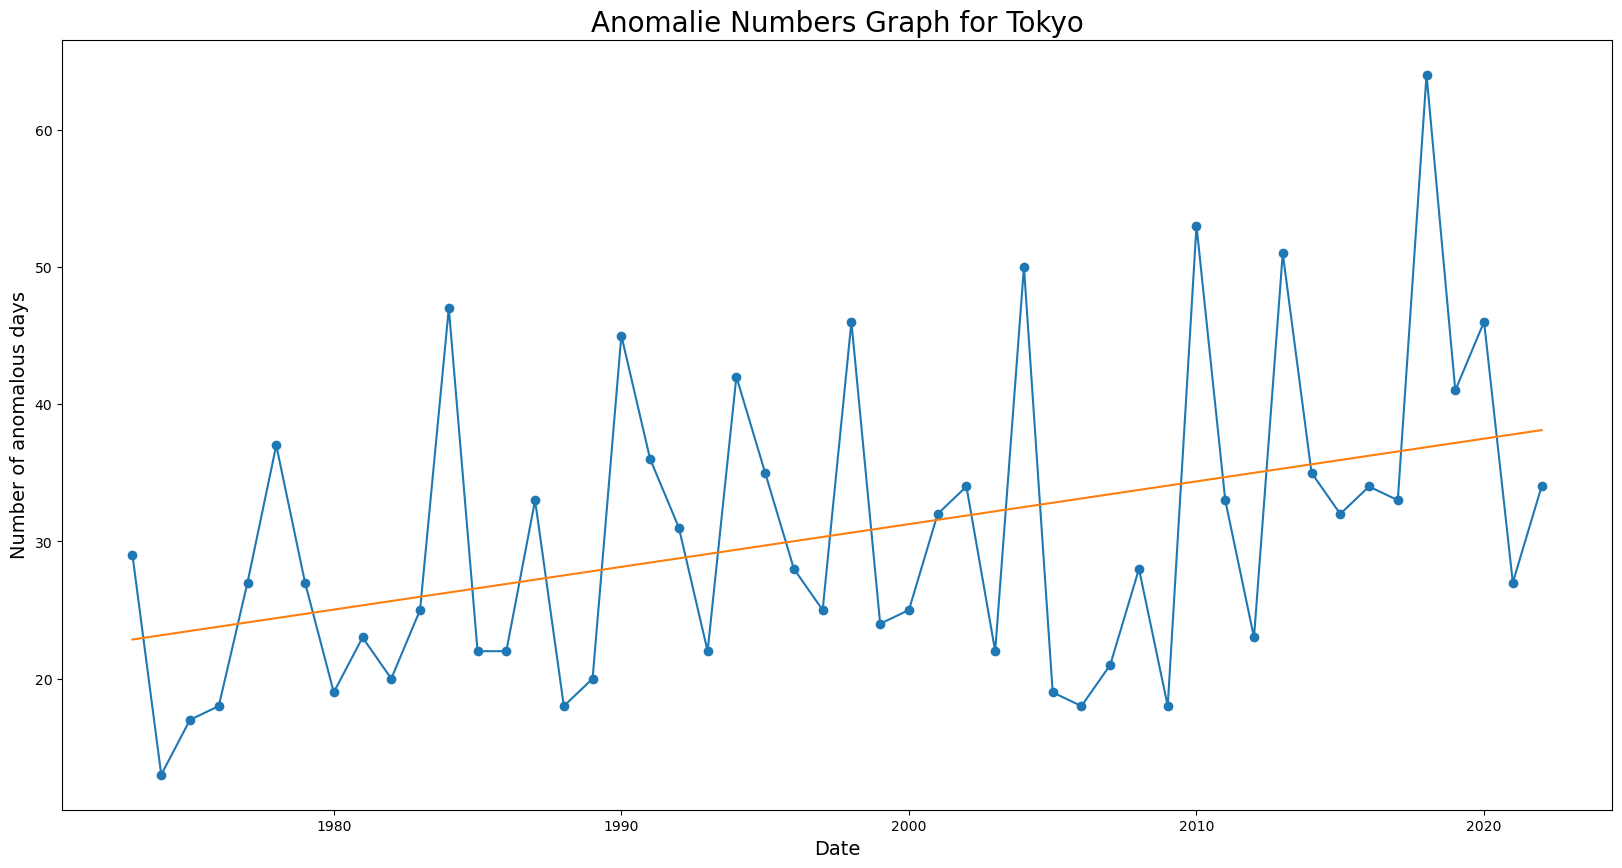

0.31135654261704676 -591.4546938775509 0.40737573637871344 0.0033220460367804484 0.10074812281810325
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is 0.020639429588710265
For column temperature_2m_max the skew is 0.4951118351476807
For column temperature_2m_min the skew is -0.17816216256273143
For column temperature_2m_mean the skew is 0.036754905479520025
For column apparent_temperature_max the skew is 0.2957237939938822
For column apparent_temperature_min the skew is -0.024298934535221615
For column apparent_temperature_mean the skew is 0.06142084285466246
For column precipitation_sum the skew is 8.48350618462244
For column rain_sum the skew is 8.48350618462244
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.6135495866865175
For column windgusts_10m_max the skew is 0.5125021769686889


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                     Variable         VIF
0                 weathercode    1.411645
1          temperature_2m_max   56.211628
2          temperature_2m_min   88.453576
3         temperature_2m_mean  250.103161
4    apparent_temperature_max   68.617524
5    apparent_temperature_min  109.900111
6   apparent_temperature_mean  300.850945
7           precipitation_sum         inf
8                    rain_sum         inf
9                snowfall_sum         NaN
10          windspeed_10m_max    7.291813
11          windgusts_10m_max    6.716215


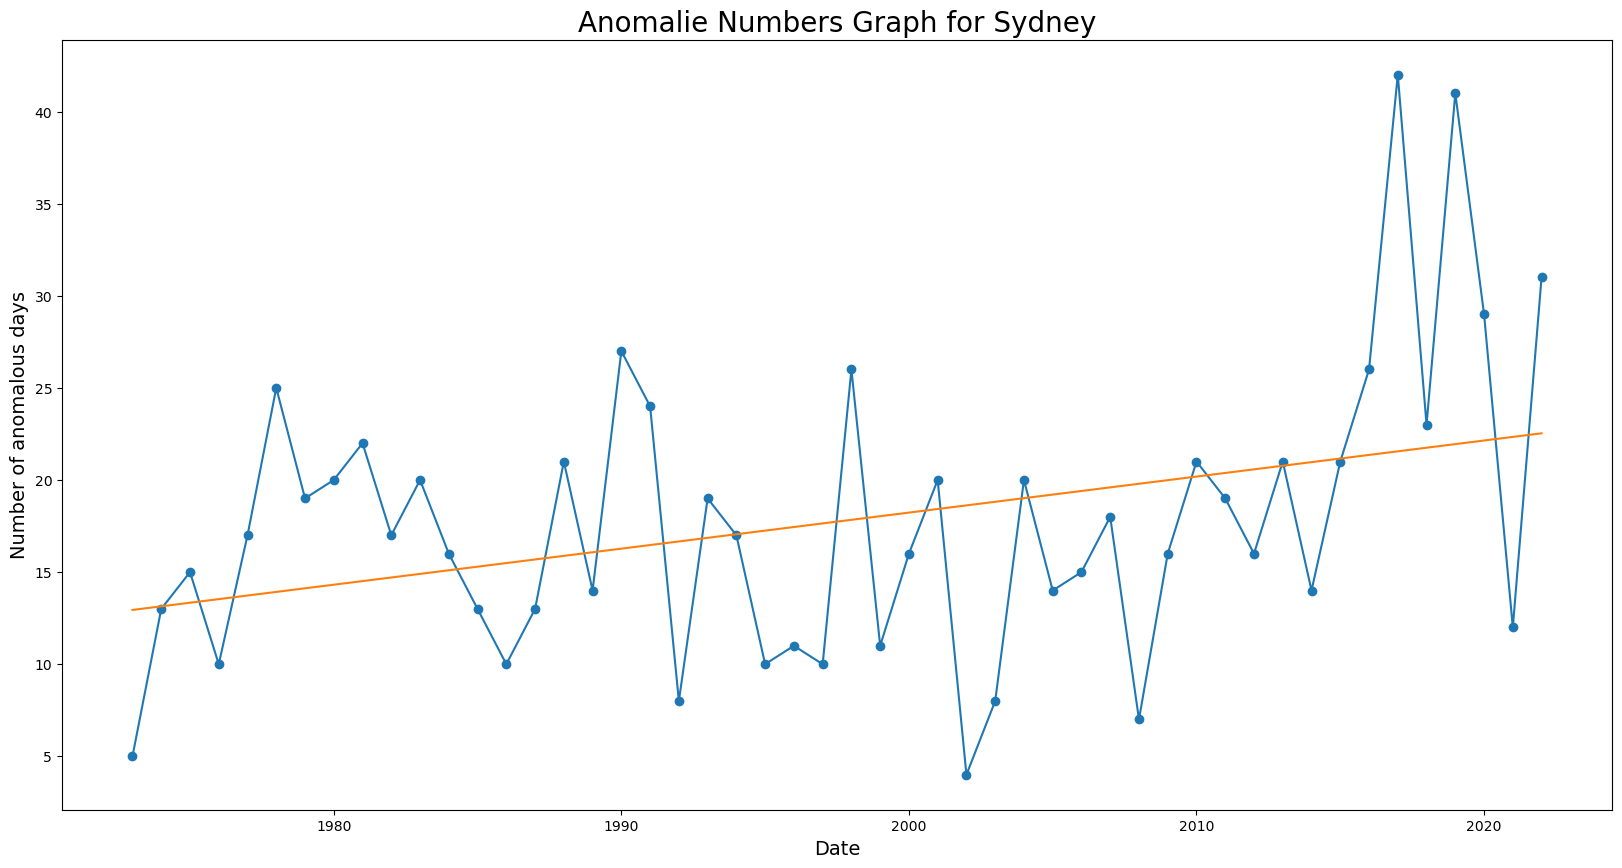

0.19567827130852344 -373.1273469387756 0.3634861232109525 0.009468965871693045 0.0723874783593617
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is 0.8334423612296618
For column temperature_2m_max the skew is 0.33465064882245416
For column temperature_2m_min the skew is -0.19730892947274598
For column temperature_2m_mean the skew is 0.22056088976206165
For column apparent_temperature_max the skew is 0.2352958914313783
For column apparent_temperature_min the skew is -0.0038513360476145524
For column apparent_temperature_mean the skew is 0.22985093388970082
For column precipitation_sum the skew is 5.105447730015882
For column rain_sum the skew is 5.105447730015882
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.3936365651724929
For column windgusts_10m_max the skew is 0.33729709353522097


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                     Variable         VIF
0                 weathercode    2.033358
1          temperature_2m_max   67.923118
2          temperature_2m_min   51.524482
3         temperature_2m_mean  197.624161
4    apparent_temperature_max   66.065878
5    apparent_temperature_min   60.715259
6   apparent_temperature_mean  200.946864
7           precipitation_sum         inf
8                    rain_sum         inf
9                snowfall_sum         NaN
10          windspeed_10m_max    9.274239
11          windgusts_10m_max    8.946585


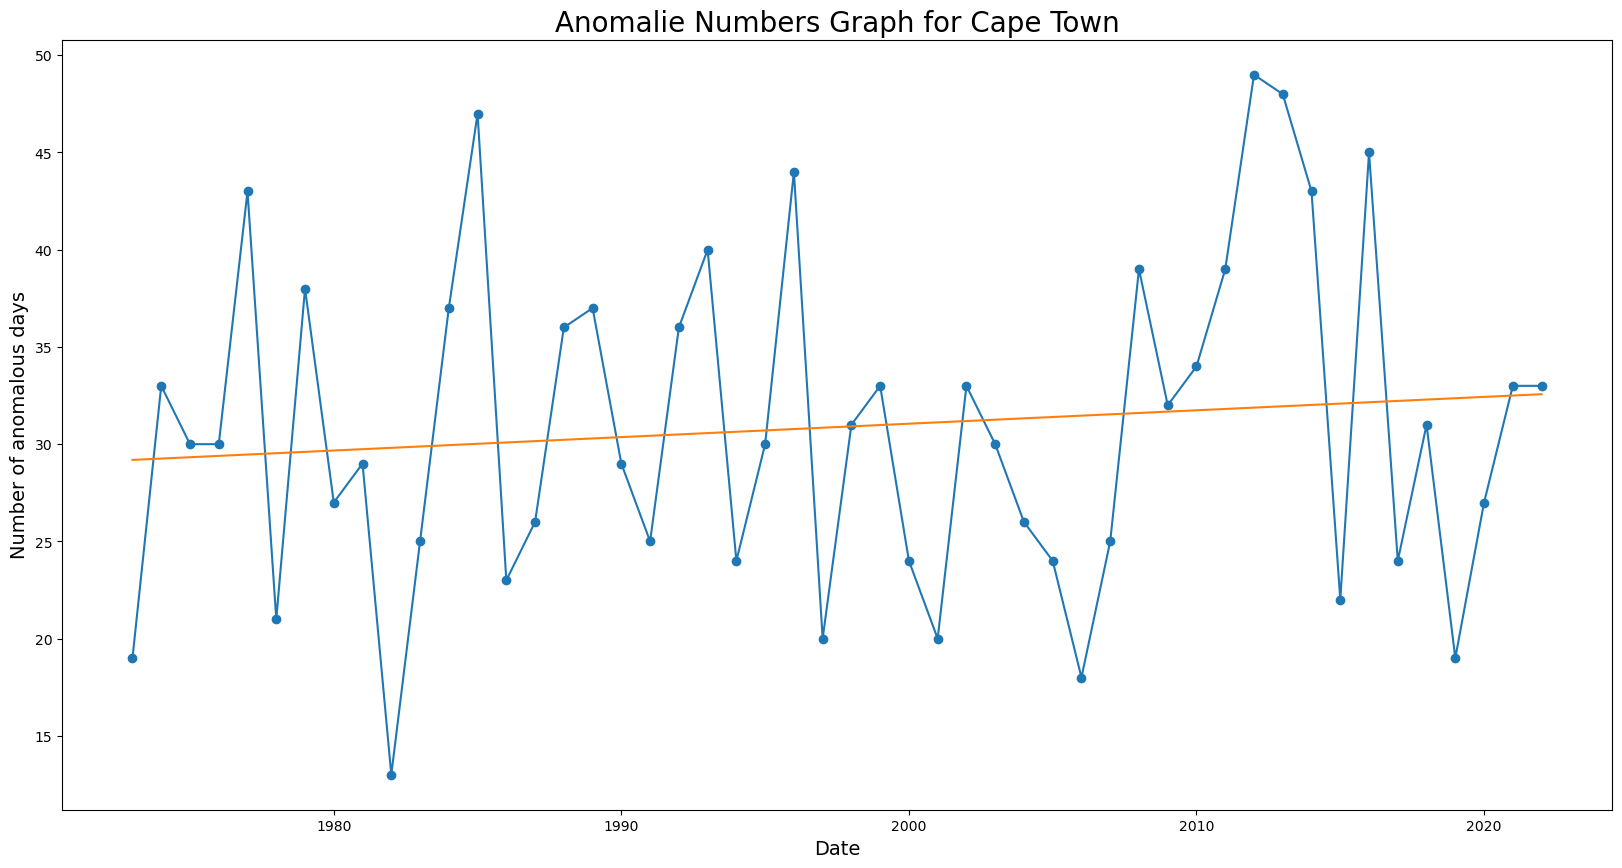

0.06895558223289318 -106.85877551020414 0.11731669385485836 0.4171475345675063 0.0842518791218795
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is -0.2999922908055065
For column temperature_2m_max the skew is 0.10457508779964876
For column temperature_2m_min the skew is -0.2922133845420217
For column temperature_2m_mean the skew is 0.10527013879749203
For column apparent_temperature_max the skew is 0.04293439615508062
For column apparent_temperature_min the skew is -0.17097792398413617
For column apparent_temperature_mean the skew is 0.031549732226600596
For column precipitation_sum the skew is 6.496317103569054
For column rain_sum the skew is 6.496317103569054
For column snowfall_sum the skew is 0
For column windspeed_10m_max the skew is 0.9159902973145592
For column windgusts_10m_max the skew is 1.0215504610215649


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                     Variable         VIF
0                 weathercode    1.965584
1          temperature_2m_max   55.001818
2          temperature_2m_min   97.445538
3         temperature_2m_mean  182.156229
4    apparent_temperature_max   62.159772
5    apparent_temperature_min  105.665319
6   apparent_temperature_mean  249.271534
7           precipitation_sum         inf
8                    rain_sum         inf
9                snowfall_sum         NaN
10          windspeed_10m_max    5.053705
11          windgusts_10m_max    4.961502


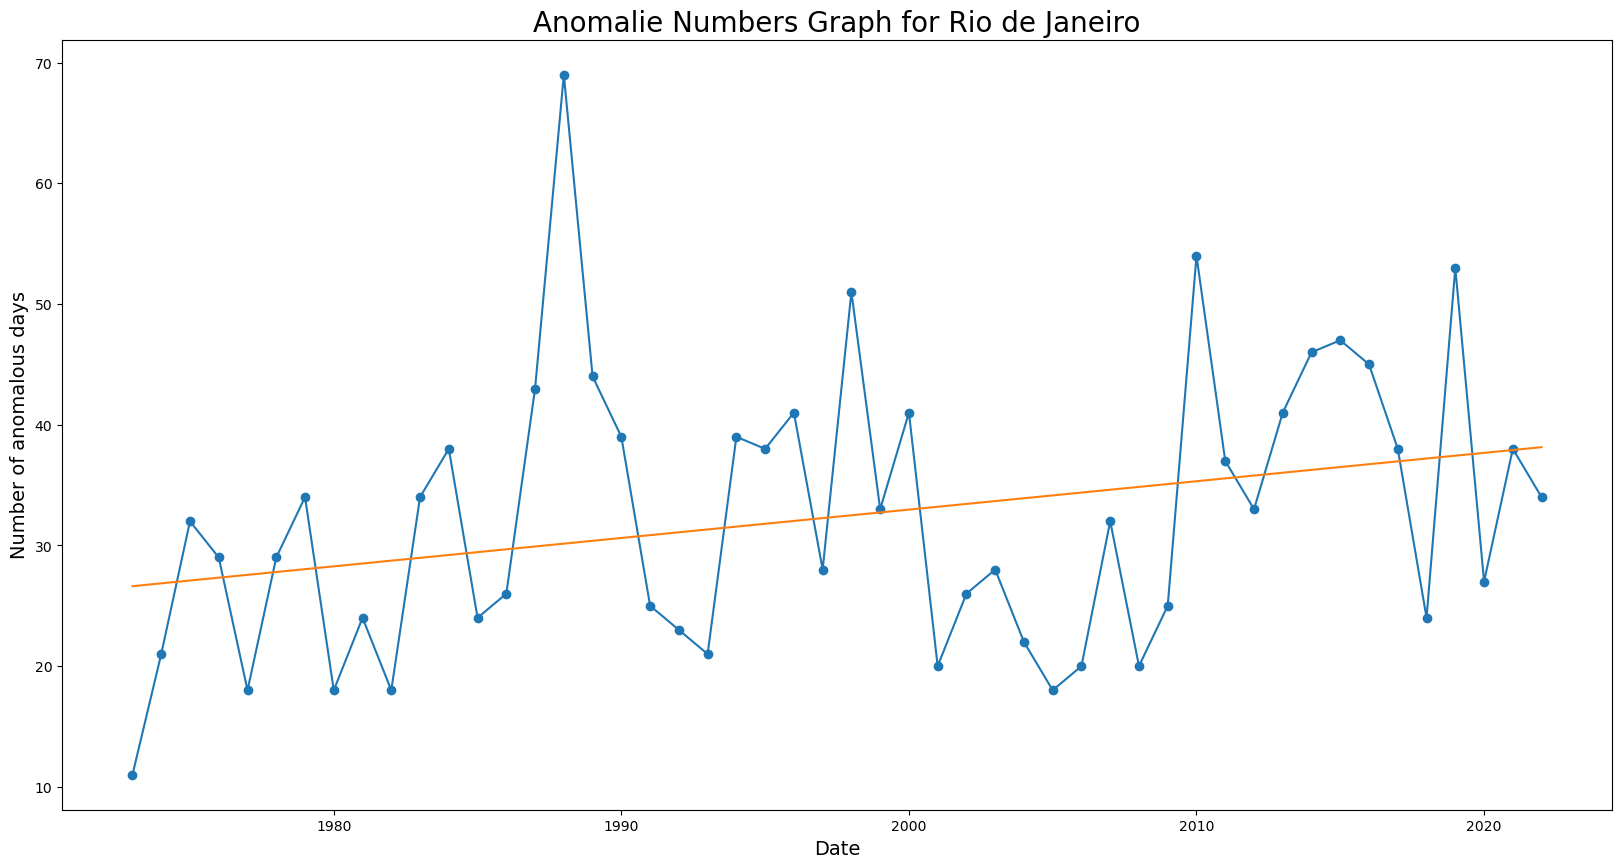

0.2350540216086435 -437.1404081632654 0.2965041991053394 0.03654200792440275 0.10927830188619761
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is -0.23431640326949177
For column temperature_2m_max the skew is -0.21771155980886886
For column temperature_2m_min the skew is -0.5210432540665473
For column temperature_2m_mean the skew is -0.35497134354854176
For column apparent_temperature_max the skew is -0.08501955852936065
For column apparent_temperature_min the skew is -0.3223682789817051
For column apparent_temperature_mean the skew is -0.18808303111563524
For column precipitation_sum the skew is 3.953713544607119
For column rain_sum the skew is 4.7293690214332615
For column snowfall_sum the skew is 5.044673386015413
For column windspeed_10m_max the skew is 0.515999657884203
For column windgusts_10m_max the skew is 0.5110229600028166


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


                     Variable          VIF
0                 weathercode     1.624820
1          temperature_2m_max   776.080300
2          temperature_2m_min   577.593028
3         temperature_2m_mean  2119.572255
4    apparent_temperature_max   847.932688
5    apparent_temperature_min   669.460796
6   apparent_temperature_mean  2426.791122
7           precipitation_sum   934.304672
8                    rain_sum   823.610907
9                snowfall_sum   175.671521
10          windspeed_10m_max    13.532953
11          windgusts_10m_max    12.724762


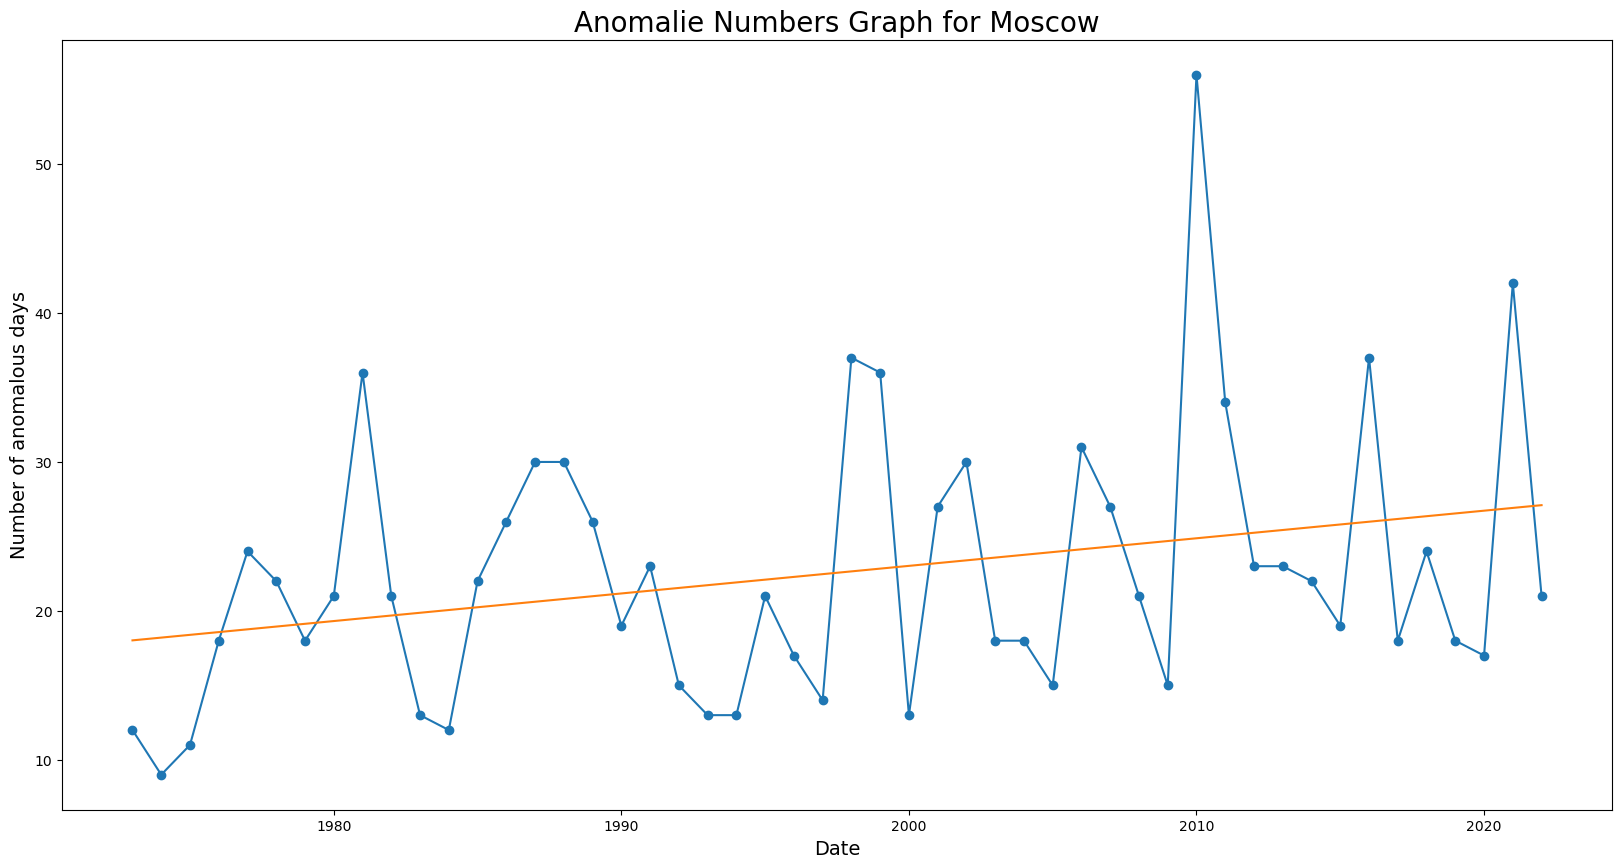

0.18525810324129652 -347.4930612244898 0.2957253359326058 0.0370609322635893 0.0863764933134816
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is 0.035011059609118544
For column temperature_2m_max the skew is -0.1564739475229068
For column temperature_2m_min the skew is -0.31575922628414393
For column temperature_2m_mean the skew is -0.23968979571913565
For column apparent_temperature_max the skew is -0.04773646674202847
For column apparent_temperature_min the skew is -0.13250195007227342
For column apparent_temperature_mean the skew is -0.08962626863452285
For column precipitation_sum the skew is 3.763158960047475
For column rain_sum the skew is 4.202784613586774
For column snowfall_sum the skew is 8.054344952397324
For column windspeed_10m_max the skew is 0.6496999871947604
For column windgusts_10m_max the skew is 0.7963416397602434


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


                     Variable          VIF
0                 weathercode     1.598223
1          temperature_2m_max   281.435309
2          temperature_2m_min   481.931686
3         temperature_2m_mean  1238.001274
4    apparent_temperature_max   297.831418
5    apparent_temperature_min   518.594425
6   apparent_temperature_mean  1305.497992
7           precipitation_sum  4503.760743
8                    rain_sum  3970.989888
9                snowfall_sum   568.506026
10          windspeed_10m_max     9.574159
11          windgusts_10m_max     8.531661


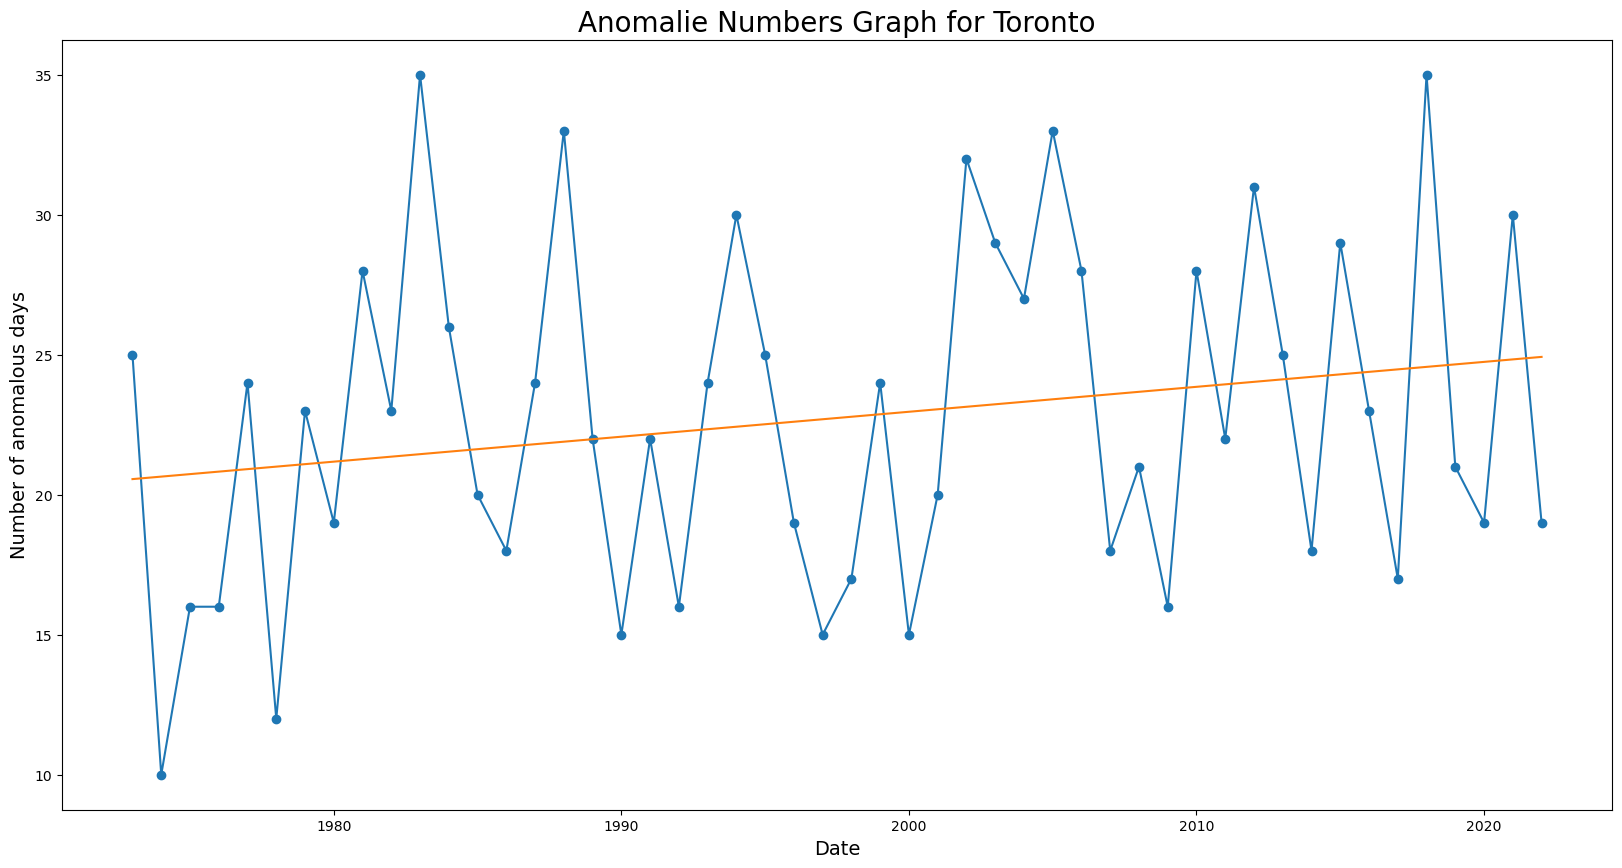

0.08907563025210083 -155.1885714285714 0.2122666385161744 0.13889684015662906 0.05918957736214777
Are missing values present?  [True]
There are  4  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
----------
For column weathercode the skew is -0.6475832601399074
For column temperature_2m_max the skew is -0.449814837793761
For column temperature_2m_min the skew is -0.7093471106594645
For column temperature_2m_mean the skew is -0.6058565201835712
For column apparent_temperature_max the skew is -0.26684907013507725
For column apparent_temperature_min the skew is -0.4449045687259984
For column apparent_temperature_mean the skew is -0.3673072776750169
For column precipitation_sum the skew is 2.2179994456313565
For column rain_sum the skew is 2.439724059548076
For column snowfall_sum the skew is 5.179567025300867
For column windspeed_10m_max the skew is 0.6633498304516261
For column windgusts_10m_max the skew is 0.8079480099292335


/tmp/ipykernel_32/3467474077.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


                     Variable          VIF
0                 weathercode     1.577881
1          temperature_2m_max   127.728364
2          temperature_2m_min   113.033745
3         temperature_2m_mean   448.434573
4    apparent_temperature_max   143.758409
5    apparent_temperature_min   146.271258
6   apparent_temperature_mean   538.530002
7           precipitation_sum  3842.326488
8                    rain_sum  3326.435678
9                snowfall_sum   514.196875
10          windspeed_10m_max    23.339935
11          windgusts_10m_max    22.032463


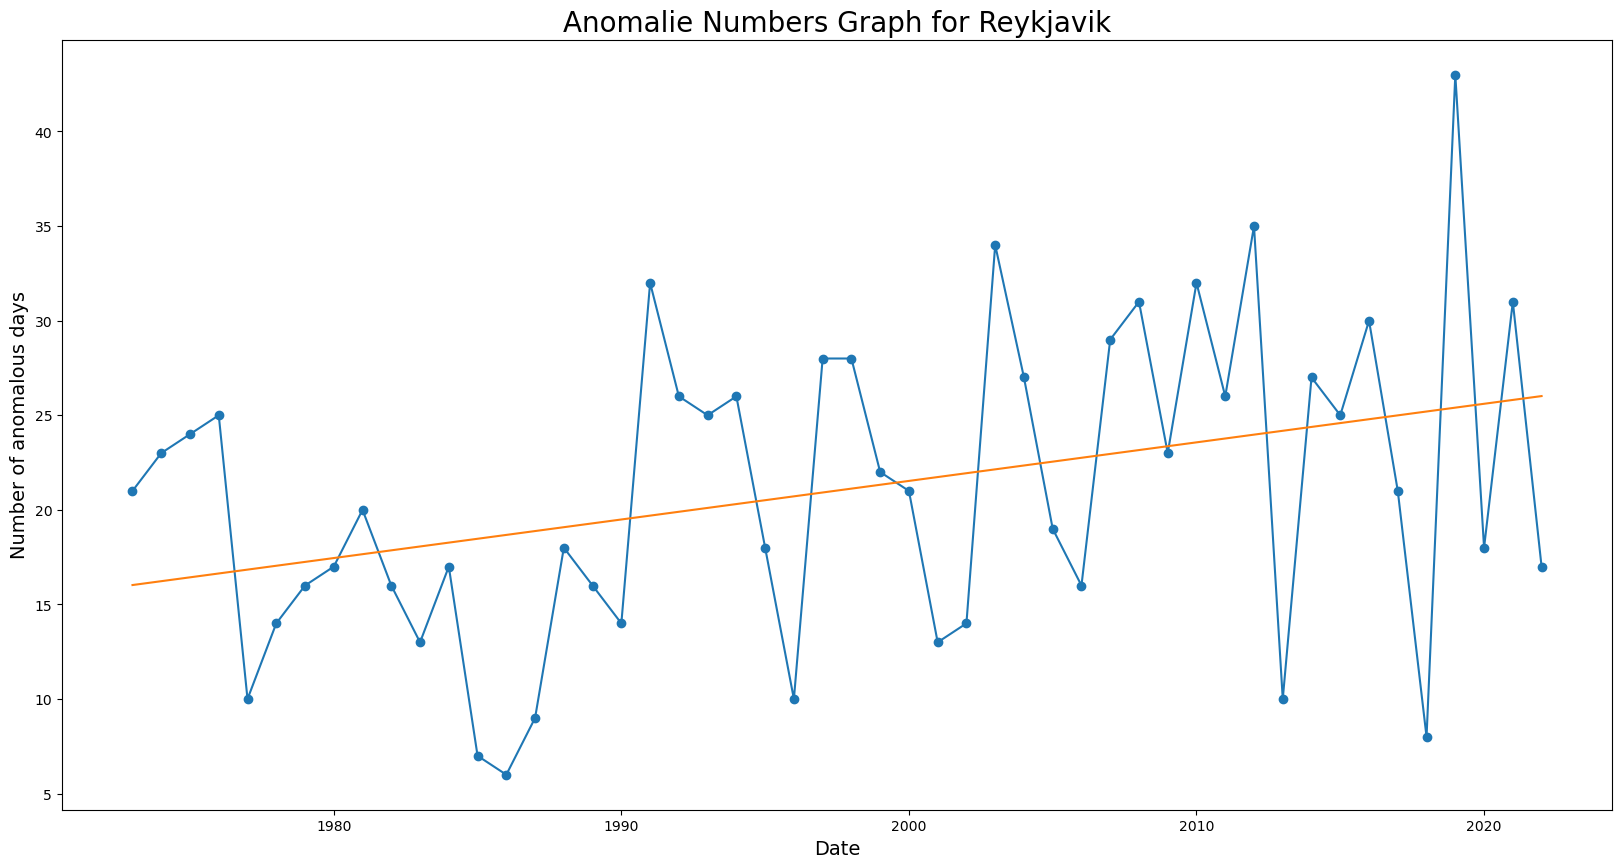

0.20384153661464588 -386.15346938775514 0.3621432129761293 0.009756384402769543 0.07572943057842917


In [985]:
for city in location_names:
    data_worker = DataWorker(weather_df,city)
    data_worker.na_check().datetime_index_na_check().check_duplicates().get_float_cols()
    #data_worker.data.drop(['apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max'],axis=1,inplace=True)
    #data_worker.float_columns=[col for col in data_worker.float_columns if col not in ['apparent_temperature_max','apparent_temperature_min','temperature_2m_min','windspeed_10m_max']]
    print('-'*10)
    data_worker.check_uniform(False).train_test().normalize(False,False).compute_vif()
    
    #25,1.0,3
    model=IsolationForest(n_estimators=25,max_samples=1.0,max_features=3,random_state=0)
    model.fit(data_worker.X_train)
    scores = model.predict(data_worker.X_test)
    index = where(scores == -1)
    outliers = data_worker.X_test_orig.iloc[index]
    outliers=pd.DataFrame(outliers)
    outliers.to_csv(f'IsolationForest_outliers_{city}.csv')

    
    data_worker.X_test_orig['time']=pd.to_datetime(data_worker.X_test_orig.loc[:,'time'],format='%Y-%m-%d')
    outliers = data_worker.X_test_orig.iloc[index].groupby(data_worker.X_test_orig['time'].dt.year).count()
    plt.figure(figsize=(20,10))
    plt.plot(outliers.iloc[:,-1])
    a, b = np.polyfit(np.array(np.linspace(min(data_worker.X_test_orig['time'].dt.year),max(data_worker.X_test_orig['time'].dt.year),num=len(outliers))), outliers.iloc[:,-1], 1)
    x=np.array(np.linspace(min(data_worker.X_test_orig['time'].dt.year),max(data_worker.X_test_orig['time'].dt.year),num=len(outliers)))
    y=outliers.iloc[:,-1]
    plt.scatter(x, y)

    #add line of best fit to plot
    plt.plot(x, a*x+b)   
    plt.title(f'Anomalie Numbers Graph for {city}',fontsize=20)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Number of anomalous days',fontsize=14)
    plt.show()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(slope,intercept,r_value,p_value,std_err)

In [991]:
import shutil
shutil.make_archive('data', 'zip', '/kaggle/working/')


KeyboardInterrupt



In [992]:
!cd /kaggle/working

In [994]:
!rm 'data.zip'